<a href="https://colab.research.google.com/github/techoff/second_year_coursework/blob/main/coursework_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Теория

---

Продольные данные МРТ у пожилых людей без деменции и с деменцией: Этот набор состоит из лонгитюдной коллекции 150 субъектов в возрасте от 60 до 96 лет. Каждый субъект был просканирован во время двух или более посещений с промежутком не менее одного года, всего 373 сеанса визуализации. Для каждого субъекта включены 3 или 4 отдельных Т1-взвешенных МРТ, полученных в ходе одного сеанса сканирования. Все испытуемые правши и включают как мужчин, так и женщин. 72 субъекта были охарактеризованы как не страдающие деменцией на протяжении всего исследования. 64 из включенных субъектов были охарактеризованы как слабоумные во время их первоначальных посещений и оставались таковыми для последующих сканирований, включая 51 человека с болезнью Альцгеймера легкой и средней степени тяжести. Еще 14 субъектов были охарактеризованы как не страдающие деменцией во время их первоначального визита, а затем были охарактеризованы как деменция при более позднем визите.

# Библиотеки

---



In [1]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, StackingClassifier
from numpy import mean, std


# Предварительная обработка данных

---



In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/coursework/oasis_longitudinal.csv', delimiter = ',')
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


## Удаление данных, не имеющих отношения к целевой переменнной

In [4]:
data['Hand'].unique()

array(['R'], dtype=object)

изначально удалил последующие визиты, остались только первые, данных стало 142, против 354 сейчас, до / после удаления (kNN):

MSE = 0.89 // 0.53

Accuracy = 0.51 // 0.71

после этого еще удалил в Group строки со значением Converted (те у кого сначала не было выявлено деменции, но на последующих приемах она была), данных стало 317

MSE = 0.17

Accuracy = 0.83


In [5]:
# data = data.loc[data['Visit'] == 1]
data = data.loc[(data['Group'] == 'Demented') | (data['Group'] == 'Nondemented')]
data = data.drop('Subject ID', axis = 1)
data = data.drop('Visit', axis = 1)
data = data.drop('MRI ID', axis = 1)
data = data.drop('MR Delay', axis = 1)
data = data.drop('Hand', axis = 1)

data.head()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


## Проверка на наличие NaN-значений

In [6]:
data.isna().any()

Group    False
M/F      False
Age      False
EDUC     False
SES       True
MMSE      True
CDR      False
eTIV     False
nWBV     False
ASF      False
dtype: bool

In [7]:
data['SES'].isna().sum()

19

In [8]:
data['SES'].value_counts()

2.0    96
3.0    75
4.0    72
1.0    67
5.0     7
Name: SES, dtype: int64

In [9]:
data = data[(data['SES'] == 1) | (data['SES'] == 2) | (data['SES'] == 3) | (data['SES'] == 4) | (data['SES'] == 5)]

In [10]:
data.isna().any().any()

False

In [11]:
data.head()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
5,Nondemented,F,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,Nondemented,F,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,Nondemented,M,80,12,4.0,28.0,0.0,1689,0.712,1.039


## One-hot кодирование для категориального признака 'M/F' (Пол)

In [12]:
# X.loc[:, 'M/F'] = X['M/F'].map({'M': 1, 'F':0})

In [13]:
data.reset_index(drop=True, inplace=True)

ohe_enc = OneHotEncoder(handle_unknown = 'error')
enc_gender = pd.DataFrame(ohe_enc.fit_transform(data[['M/F']]).toarray())
data = data.join(enc_gender)

data = data.drop('M/F', axis = 1)

data.head()

,Group,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,0,1
0,Nondemented,87,14,2.0,27.0,0.0,1987,0.696,0.883,0.0,1.0
1,Nondemented,88,14,2.0,30.0,0.0,2004,0.681,0.876,0.0,1.0
2,Nondemented,88,18,3.0,28.0,0.0,1215,0.710,1.444,1.0,0.0
3,Nondemented,90,18,3.0,27.0,0.0,1200,0.718,1.462,1.0,0.0
4,Nondemented,80,12,4.0,28.0,0.0,1689,0.712,1.039,0.0,1.0


## Label кодирование для категориального признака 'Group' (Наличие / Отсутствие деменции)

In [14]:
label_enc = LabelEncoder()
data['Dementia'] = label_enc.fit_transform(data['Group'])
data = data.drop('Group', axis = 1)

data.head()

,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,0,1,Dementia
0,87,14,2.0,27.0,0.0,1987,0.696,0.883,0.0,1.0,1
1,88,14,2.0,30.0,0.0,2004,0.681,0.876,0.0,1.0,1
2,88,18,3.0,28.0,0.0,1215,0.710,1.444,1.0,0.0,1
3,90,18,3.0,27.0,0.0,1200,0.718,1.462,1.0,0.0,1
4,80,12,4.0,28.0,0.0,1689,0.712,1.039,0.0,1.0,1


## Разбиение на тренировочную и тестовую выборку

In [15]:
x, y = data.drop('Dementia', axis = 1), data['Dementia']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Стандартизация / Масштабирование || Scaler 

In [16]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(x)

# x_train = scaler.transform(x_train)
# x_test = scaler.transform(x_test)

In [17]:
scaler = StandardScaler()
scaler.fit(x)

train_img = scaler.transform(x_train)
test_img = scaler.transform(x_test)
x_img = scaler.transform(x)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


# Инициализация датафрейма для метрик

In [18]:
columns_names = np.array([['Algorithm', 'Accuracy','MSE','MAE','MAPE']])
                
model_comparison = pd.DataFrame(data=columns_names[1:,1:], columns=columns_names[0,1:])

# Метод главных компонент || PCA Principal Cimponent Analysis

---



## Transform: 1 feature

In [19]:
sns.set(rc = {'figure.figsize':(15,8)})

pca = PCA(n_components=1)
pca.fit(x_train.values, y_train.values)
pca_done = pca.fit_transform(x.values)

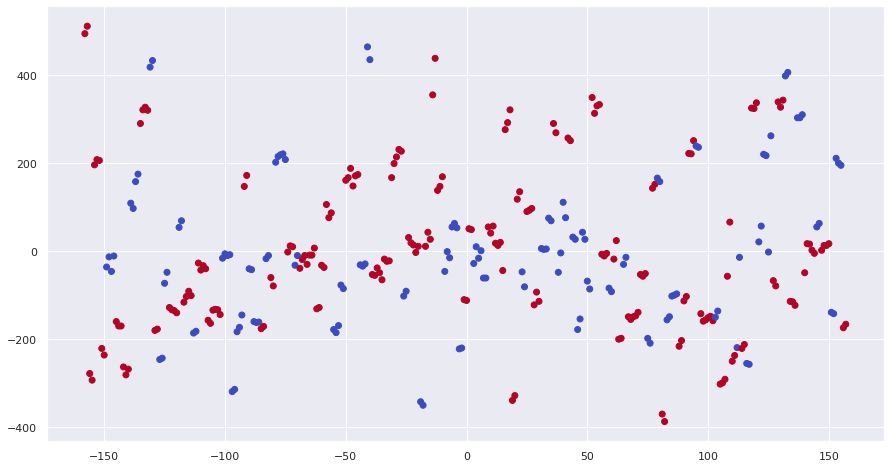

In [20]:
y1 = y[:316]
plt.scatter(range(-158,158), pca_done[:316], c=y1, cmap='coolwarm')

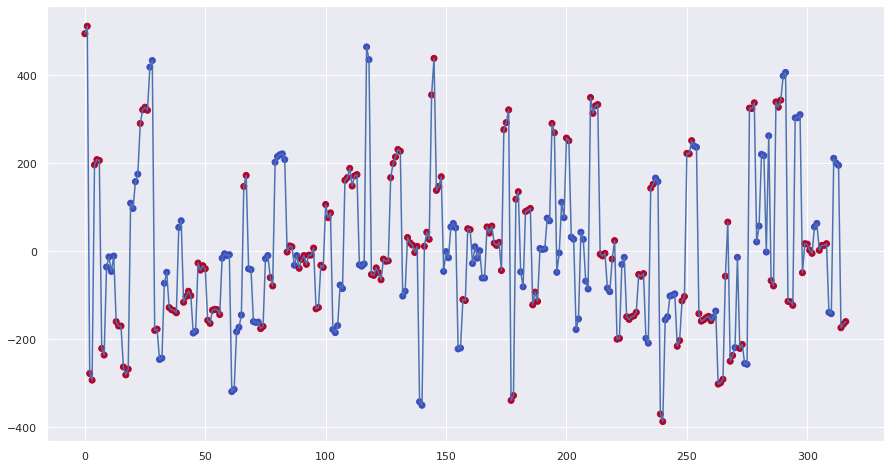

In [21]:
plt.plot(pca_done)
plt.scatter(range(317), pca_done, c=y, cmap='coolwarm')

## Transform: 2 features

In [22]:
pca = PCA(n_components=2)
pca.fit(x_train.values, y_train.values)
pca_done = pca.fit_transform(x.values)


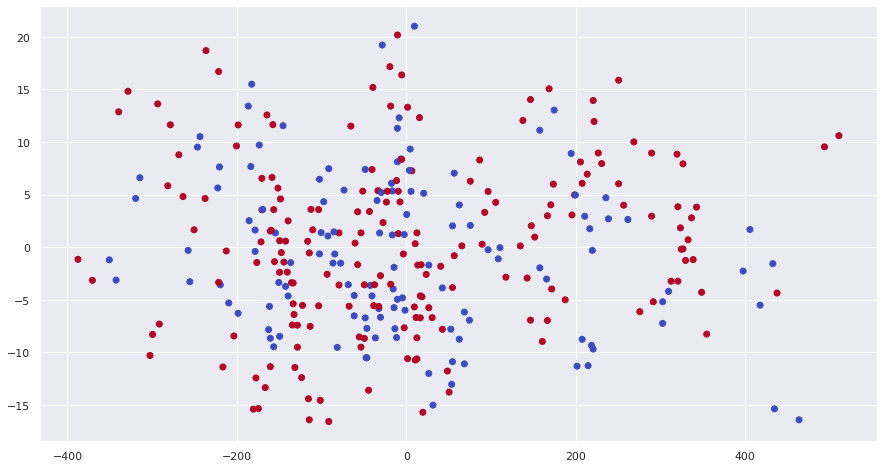

In [23]:
plt.scatter(pca_done[:,0], pca_done[:,1],c=y, cmap='coolwarm')

### Пример обучения модели классификатором KNN(neighbors=5) на двух признаках



In [24]:
x_grid, y_grid = np.meshgrid(np.linspace(-400, 500, 500), np.linspace(-20, 20, 200))
xy = np.stack([x_grid, y_grid], axis=2).reshape(-1, 2)

In [25]:
grid_searcher = GridSearchCV(KNeighborsClassifier(),
                             param_grid = {'n_neighbors': [5],
                                           'weights': ['uniform', 'distance'],
                                           'p': [1,2,3]},
                             cv = 5)

In [26]:
grid_searcher.fit(pca_done, y.values)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']})

In [27]:
grid_searcher.best_params_

{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

In [28]:
predicted = grid_searcher.predict(xy)

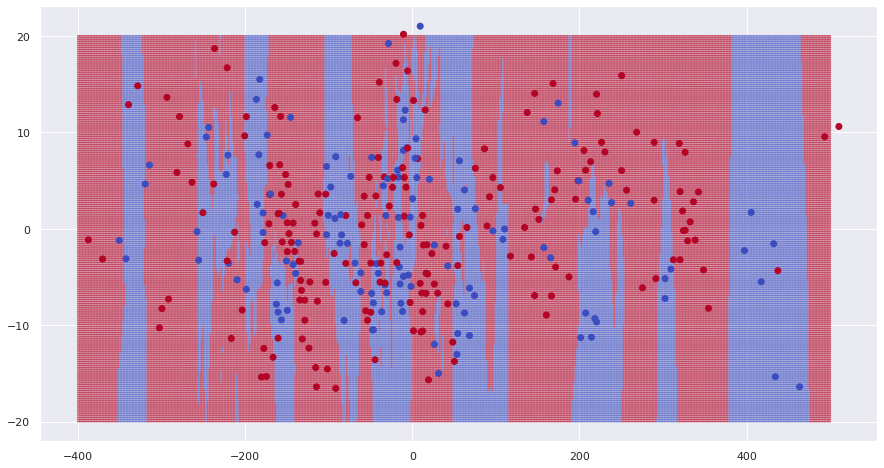

In [29]:
plt.scatter(xy[:, 0], xy[:, 1], c=predicted, alpha=0.5, s=1, cmap='coolwarm')
plt.scatter(pca_done[:, 0], pca_done[:, 1], c=y, cmap='coolwarm')

## 3-Dimensional

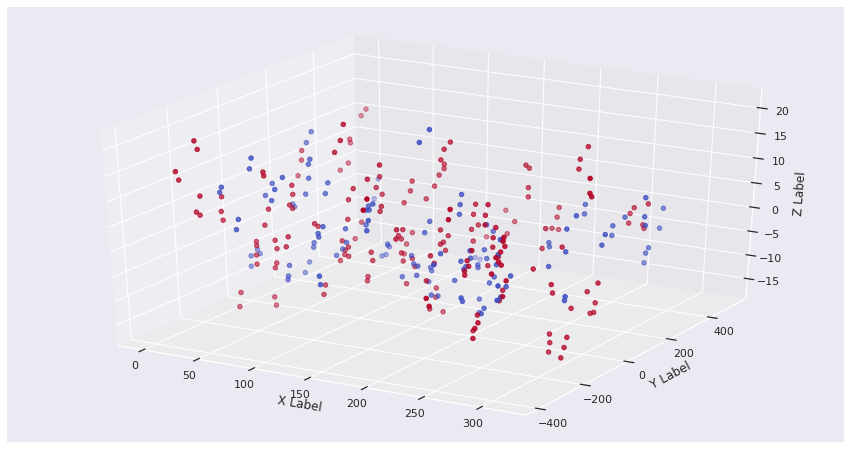

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = range(317)
ys = pca_done[:,0]
zs = pca_done[:,1]
ax.scatter(xs, ys, zs, c=y, cmap='coolwarm')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# Графики

---



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec0eeef750>,
      dtype=object)

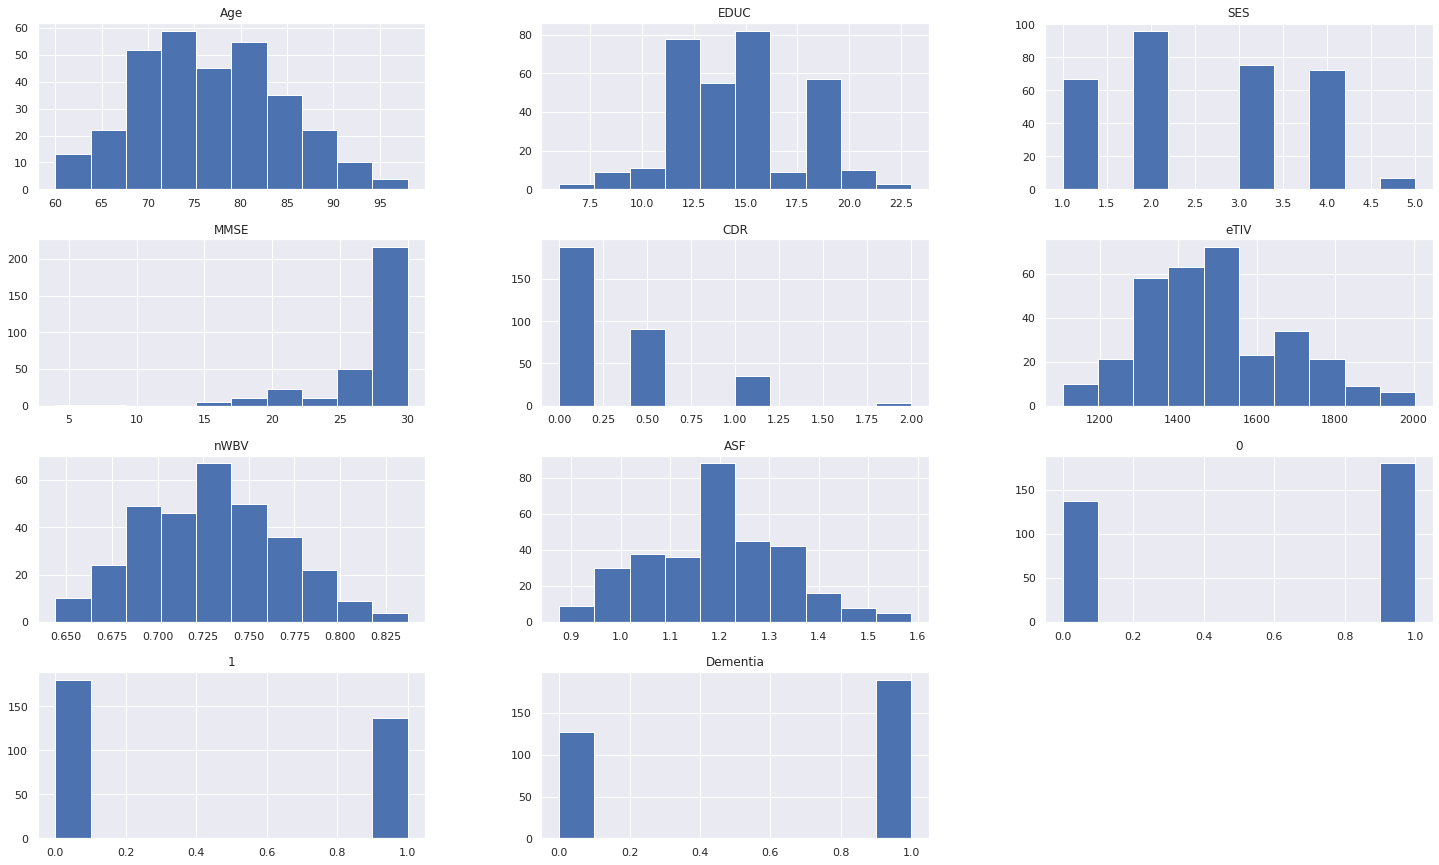

In [31]:
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc = {'figure.figsize':(25,15)})
data.hist()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


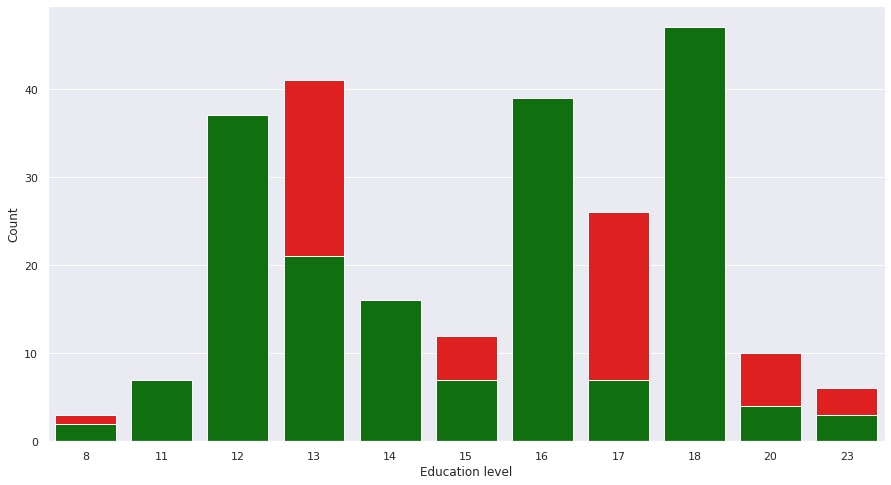

In [32]:
sns.set(rc = {'figure.figsize':(15,8)})

df_0 = data[data['Dementia'] == 0].EDUC
df_1 = data[data['Dementia'] == 1].EDUC
# df_2 = data[data['Dementia'] == 2].EDUC
sns.countplot(df_0, color='red')
sns.countplot(df_1, color='green')
# sns.countplot(df_2, color='yellow')
plt.ylabel('Count')
plt.xlabel('Education level')
plt.show()

Text(0.5, 0, 'Education level')

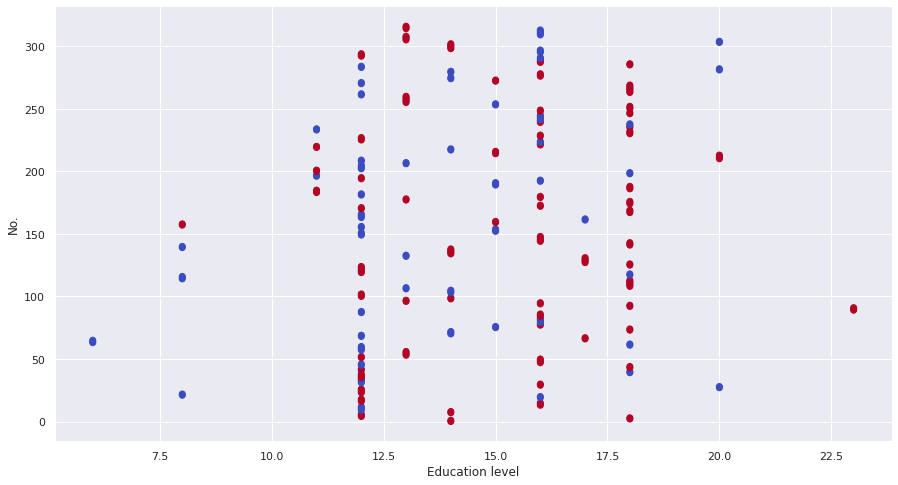

In [33]:
plt.scatter(data['EDUC'], range(317), c=data['Dementia'], cmap='coolwarm')
plt.ylabel('No.')
plt.xlabel('Education level')

Text(0.5, 0, 'Age')

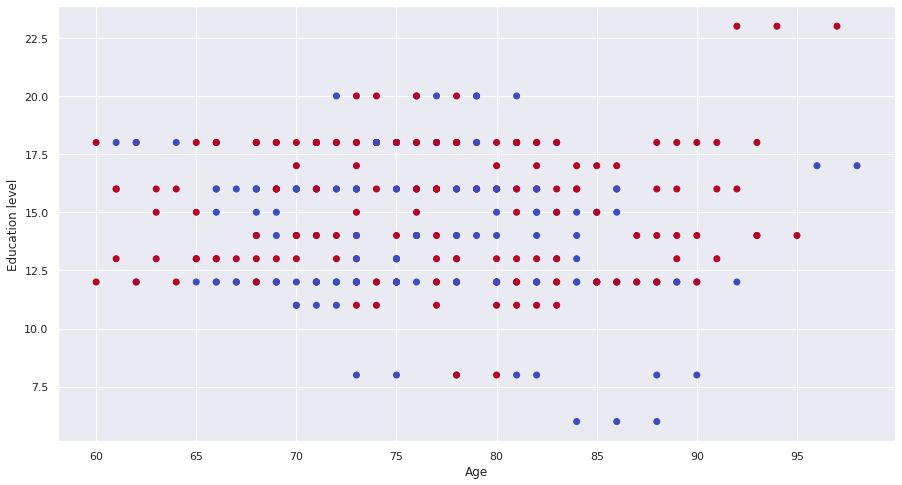

In [34]:
plt.scatter(data['Age'], data['EDUC'], c=data['Dementia'], cmap='coolwarm')
plt.ylabel('Education level')
plt.xlabel('Age')


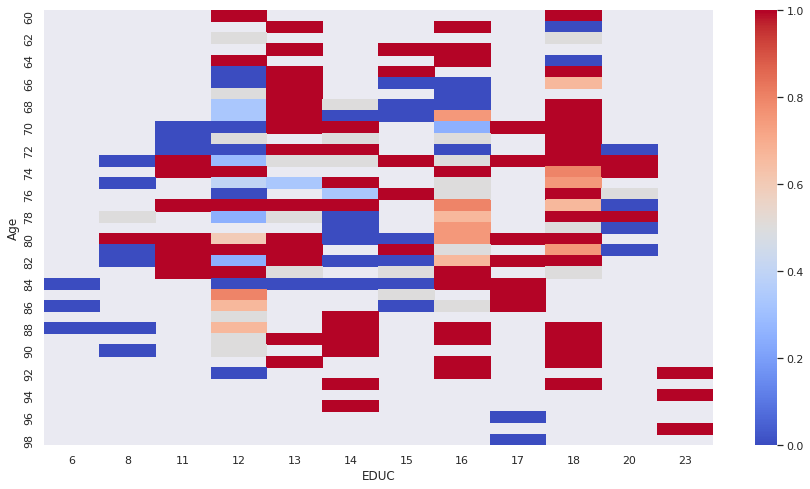

In [35]:
pivot = data.pivot_table(
    index=["Age"],
    columns=["EDUC"],
    values="Dementia",
    aggfunc=np.average)
sns.heatmap(pivot, cmap='coolwarm')

In [36]:
# plt.imshow((data["Age"], data['EDUC']), data['Dementia'])

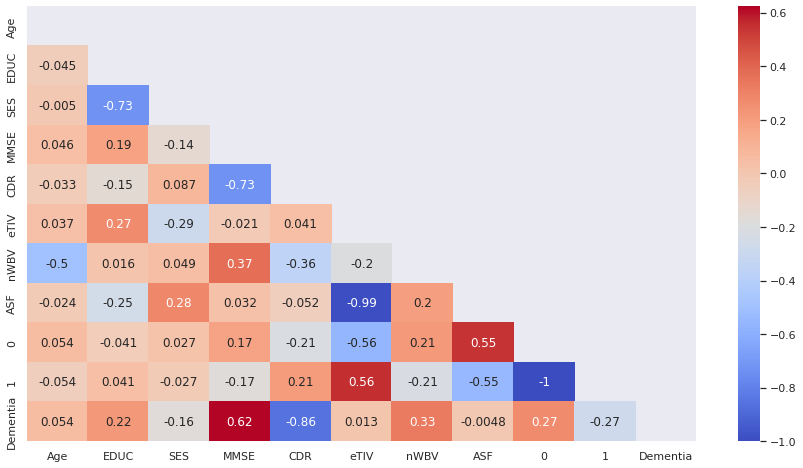

In [37]:
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True, mask=matrix, cmap='coolwarm')

# sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


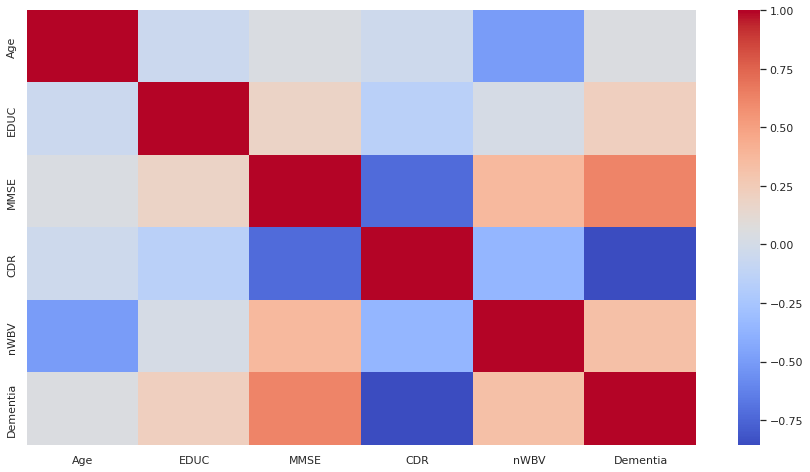

In [38]:
q = data.drop('SES', axis=1)
# q = q.drop('MMSE', axis=1)
# q = q.drop('CDR', axis=1)
q = q.drop('eTIV', axis=1)
# q = q.drop('nWBV', axis=1)
q = q.drop('ASF', axis=1)
# q = q.drop('Age', axis=1)
q = q.drop(0, axis=1)
q = q.drop(1, axis=1)

sns.heatmap(q.corr(), cmap='coolwarm')

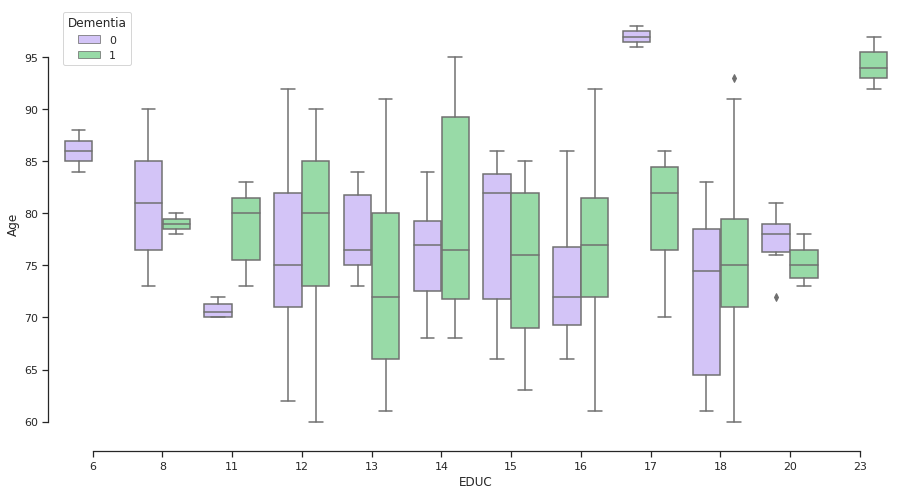

In [39]:
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="EDUC", y="Age",
            hue="Dementia", palette=["m", "g"],
            data=q)
sns.despine(offset=10, trim=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec0e935e50>,
      dtype=object)

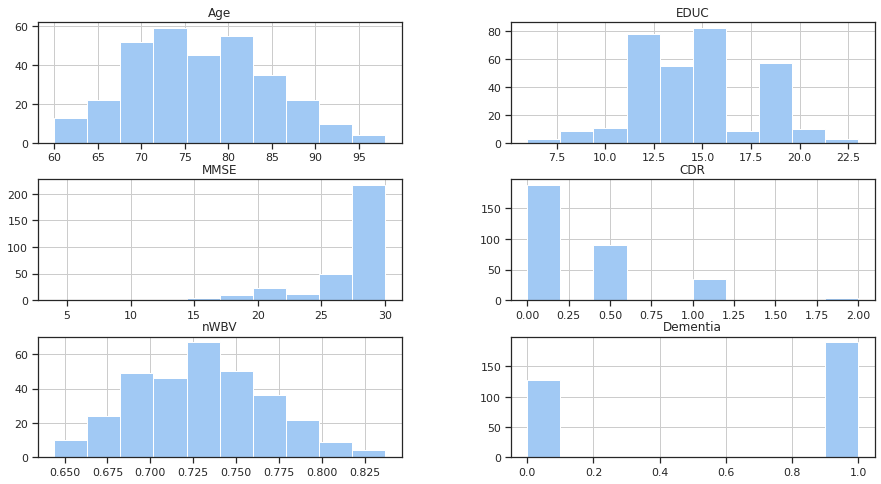

In [40]:
q.hist()

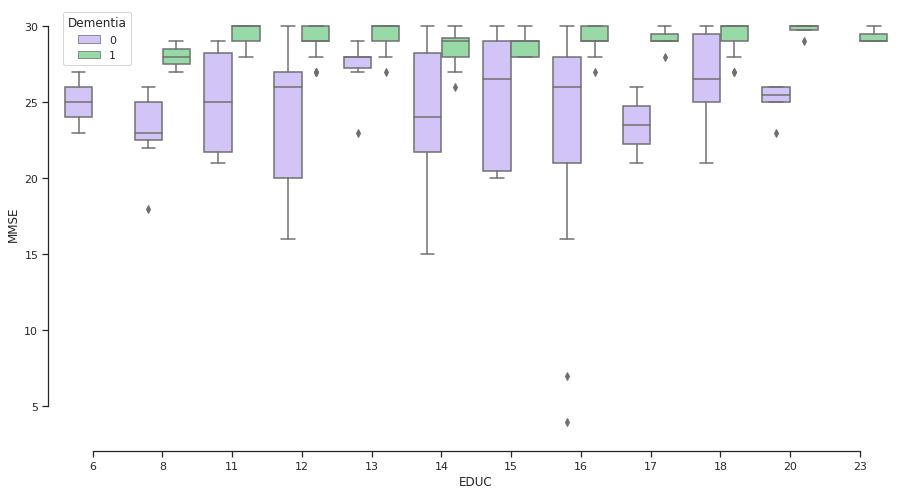

In [41]:
# sns.boxplot(data["EDUC"], data["MMSE"], hue = "Dementia")
# plt.show()
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset


# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="EDUC", y="MMSE",
            hue="Dementia", palette=["m", "g"],
            data=q)
sns.despine(offset=10, trim=True)

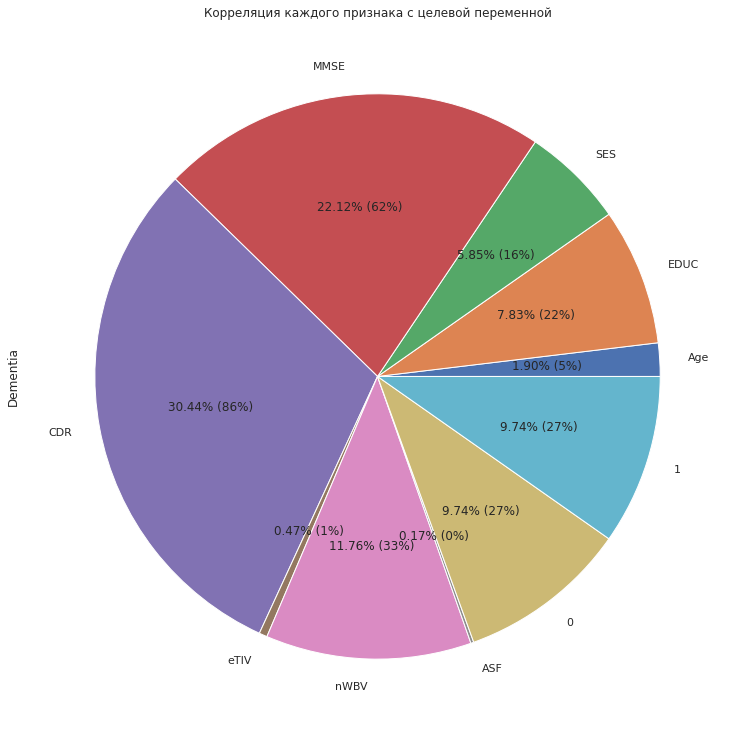

In [42]:
g = np.abs(data[['Age','EDUC', 'SES', 'MMSE', 'CDR', 'eTIV','nWBV', 'ASF', 0, 1, 'Dementia']].corr()['Dementia'].drop('Dementia', axis=0)) * 100

sns.set()

g.plot.pie(
       title='Корреляция каждого признака с целевой переменной', 
       figsize=[13,13],
       autopct=lambda p: '{:.2f}% ({:.0f}%)'.format(p,(p/100)*g.sum()))

plt.show()

In [43]:
g

Age      5.364934
EDUC    22.056522
SES     16.471494
MMSE    62.328206
CDR     85.789195
eTIV     1.310634
nWBV    33.129154
ASF      0.475879
0       27.437569
1       27.437569
Name: Dementia, dtype: float64

# K ближайших соседей || K Nearest Neighbors

---



## Выбор оптимальных гиперпараметров

In [44]:
grid_searcher = GridSearchCV(KNeighborsClassifier(),
                             param_grid = {'n_neighbors': range(1, 100),
                                           'weights': ['uniform', 'distance'],
                                           'p': [1,2,3]},
                             cv = 5)

## Тренировка модели и создание предсканий

In [45]:
grid_searcher.fit(x_train.values, y_train.values)
knn_predictions = grid_searcher.predict(x_test.values)

In [46]:
grid_searcher.best_params_

{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

## MSE (Mean Squared Error)

In [47]:
mean_squared_error(y_test, knn_predictions)

0.21875

### Зависимость MSE от кол-ва соседей

In [48]:
metrics = []
for n in range(1, 100):
  knn = KNeighborsClassifier(n_neighbors=n)
  scores = cross_val_score(knn, x_train.values, y_train.values, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Number of neightbors')

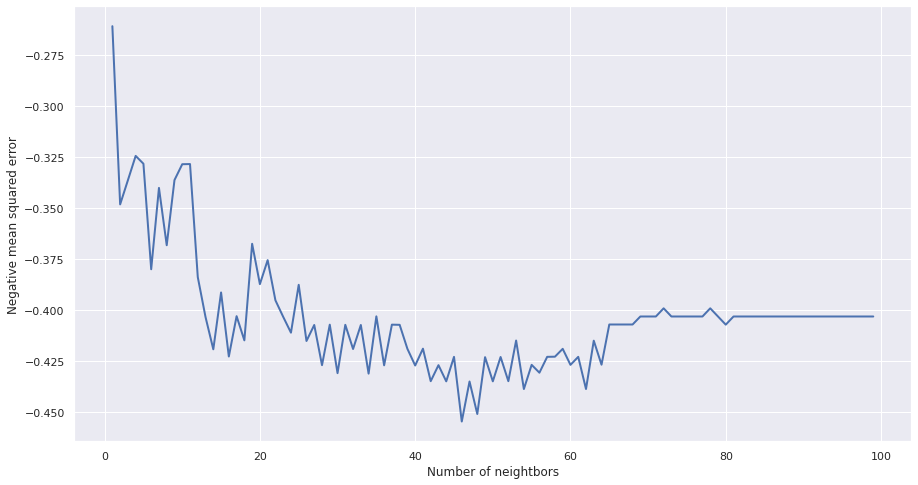

In [49]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(1, 100), metrics, linewidth=2)
plt.ylabel('Negative mean squared error')
plt.xlabel('Number of neightbors')

## Accuracy

In [50]:
accuracy = accuracy_score(y_test, knn_predictions)
accuracy

0.78125

### Зависимость Accuracy от количества соседей

In [51]:
metrics = []
for n in range(1, 100):
  knn = KNeighborsClassifier(n_neighbors=n)
  scores = cross_val_score(knn, x_train.values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Number of neightbors')

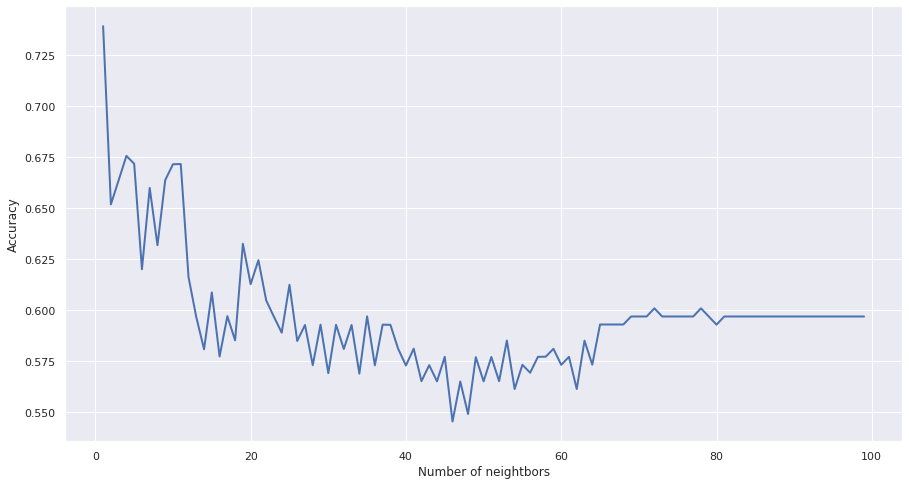

In [52]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(1, 100), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('Number of neightbors')

## Запись метрик качества 

In [53]:
acc = accuracy_score(y_test, knn_predictions)
mse = mean_squared_error(y_test, knn_predictions)
mae = mean_absolute_error(y_test, knn_predictions)
mape = mean_absolute_percentage_error(y_test, knn_predictions)

model_comparison = model_comparison.append({'Algorithm': 'K Nearest Neighbors', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Линейная регрессия || Linear Regression

---



## Выбор оптимальных гиперпараметров и тренировка модели

In [54]:
grid_searcher = GridSearchCV(LinearRegression(),
                             param_grid={'fit_intercept': [True, False]},
                             cv=5)
grid_searcher.fit(x_train.values, y_train.values)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]})

In [55]:
grid_searcher.best_params_

{'fit_intercept': False}

## Создание предсказаний

In [56]:
linreg_predictions = grid_searcher.predict(x_test.values)

## MSE (Mean Squared Error)

In [57]:
mean_squared_error(y_test, linreg_predictions)

0.063759287582657

## Accuracy

In [58]:
accuracy = accuracy_score(y_test, linreg_predictions.round())
accuracy

0.984375

## Запись метрик качества 

In [59]:
# acc = accuracy_score(y_test, linreg_predictions)
mse = mean_squared_error(y_test, linreg_predictions)
mae = mean_absolute_error(y_test, linreg_predictions)
mape = mean_absolute_percentage_error(y_test, linreg_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Linear Regression', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

In [60]:
acc = accuracy_score(y_test, linreg_predictions.round())
mse = mean_squared_error(y_test, linreg_predictions.round())
mae = mean_absolute_error(y_test, linreg_predictions.round())
mape = mean_absolute_percentage_error(y_test, linreg_predictions.round())

model_comparison = model_comparison.append({'Algorithm': 'Rounded Linear Regression', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Гребневая регрессия || Ridge regression

---



## Выбор оптимальных гиперпараметров и тренировка модели

In [61]:
grid_searcher = GridSearchCV(Ridge(),
                             param_grid={'alpha': np.linspace(1, 1000, 10)},
                             cv=5)
grid_searcher.fit(x_train.values, y_train.values)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([   1.,  112.,  223.,  334.,  445.,  556.,  667.,  778.,  889.,
       1000.])})

In [62]:
grid_searcher.best_params_

{'alpha': 1.0}

In [63]:
grid_searcher = GridSearchCV(Ridge(),
                             param_grid={'alpha': np.linspace(0.0001, 1.1, 1000)},
                             cv=5)
grid_searcher.fit(x_train.values, y_train.values)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-04, 1.20100100e-03, 2.30200200e-03, 3.40300300e-03,
       4.50400400e-03, 5.60500501e-03, 6.70600601e-03, 7.80700701e-03,
       8.90800801e-03, 1.00090090e-02, 1.11100100e-02, 1.22110110e-02,
       1.33120120e-02, 1.44130130e-02, 1.55140140e-02, 1.66150150e-02,
       1.77160160e-02, 1.88170170e-02, 1.99180180e-02, 2....
       1.07467698e+00, 1.07577798e+00, 1.07687898e+00, 1.07797998e+00,
       1.07908098e+00, 1.08018198e+00, 1.08128298e+00, 1.08238398e+00,
       1.08348498e+00, 1.08458599e+00, 1.08568699e+00, 1.08678799e+00,
       1.08788899e+00, 1.08898999e+00, 1.09009099e+00, 1.09119199e+00,
       1.09229299e+00, 1.09339399e+00, 1.09449499e+00, 1.09559600e+00,
       1.09669700e+00, 1.09779800e+00, 1.09889900e+00, 1.10000000e+00])})

In [64]:
grid_searcher.best_params_

{'alpha': 0.002302002002002002}

## Создание предсказаний

In [65]:
ridreg_predictions = grid_searcher.predict(x_test.values)

## MSE (Mean Squared Error)

In [66]:
mean_squared_error(y_test, ridreg_predictions)

0.06364484616354639

### Зависимость MSE от Alpha

In [67]:
metrics = []
for n in range(10):
  ridge = Ridge(alpha=n)
  scores = cross_val_score(ridge, x_train.values, y_train.values, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.66232e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Alpha')

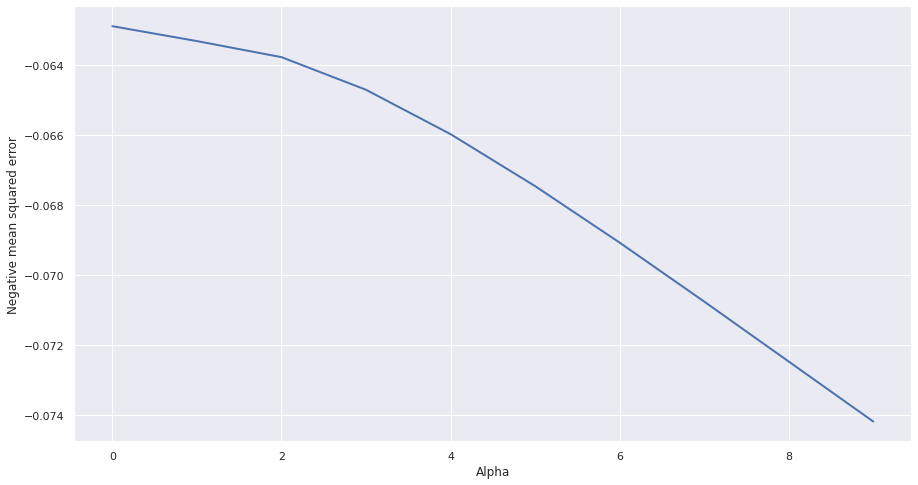

In [68]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(10), metrics, linewidth=2)
plt.ylabel('Negative mean squared error')
plt.xlabel('Alpha')

## Accuracy

In [69]:
accuracy = accuracy_score(y_test, ridreg_predictions.round())
accuracy

0.984375

### Зависимость Accuracy от Alpha

In [70]:
# metrics = []
# y_train.reset_index(drop=True, inplace=True)
# for n in range(10):
#   ridge = Ridge(alpha=n, normalize =True)
#   scores = cross_val_score(ridge, x_train.values, y_train.values, cv=5, scoring='accuracy')
#   print(scores)
#   metrics.append(np.mean(scores))

была проблема в том, что ridge предсказывает не точно, а в ответе лежат классы 0 и 1, cross_val_score не может такое посчитать

https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target

In [71]:
metrics = []
y_train.reset_index(drop=True, inplace=True)
for n in range(10):
  ridge = Ridge(alpha=n)
  ridge.fit(x_train.values, y_train.values)
  ridge_predictions = ridge.predict(x_train.values)
  scores = accuracy_score(y_train.values, ridge_predictions.round())
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Alpha')

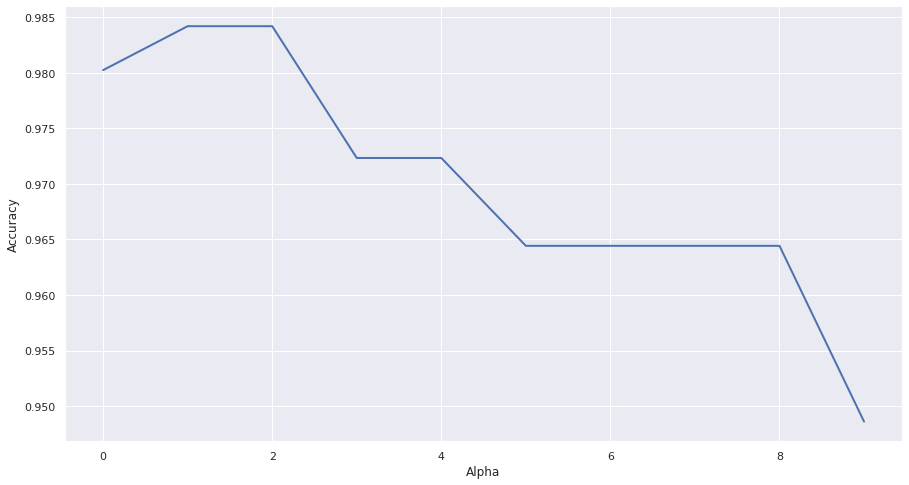

In [72]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(10), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('Alpha')

## Запись метрик качества 

In [73]:
# acc = accuracy_score(y_test, ridreg_predictions)
mse = mean_squared_error(y_test, ridreg_predictions)
mae = mean_absolute_error(y_test, ridreg_predictions)
mape = mean_absolute_percentage_error(y_test, ridreg_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Ridge Regression', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

In [74]:
acc = accuracy_score(y_test, ridreg_predictions.round())
mse = mean_squared_error(y_test, ridreg_predictions.round())
mae = mean_absolute_error(y_test, ridreg_predictions.round())
mape = mean_absolute_percentage_error(y_test, ridreg_predictions.round())

model_comparison = model_comparison.append({'Algorithm': 'Round Ridge Regression', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

## Ridge Classifier

---



In [75]:
grid_searcher = GridSearchCV(RidgeClassifier(),
                             param_grid={'alpha': np.linspace(1, 1000, 10)},
                             cv=5)
grid_searcher.fit(x_train.values, y_train.values)


GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid={'alpha': array([   1.,  112.,  223.,  334.,  445.,  556.,  667.,  778.,  889.,
       1000.])})

In [76]:
grid_searcher.best_params_

{'alpha': 1.0}

In [77]:
ridgereg_predictions = grid_searcher.predict(x_test.values)

In [78]:
mean_squared_error(y_test, ridgereg_predictions)

0.0

In [79]:
accuracy = accuracy_score(y_test, ridgereg_predictions)
accuracy

1.0

### Запись метрик качества 

In [80]:
acc = accuracy_score(y_test, knn_predictions)
mse = mean_squared_error(y_test, knn_predictions)
mae = mean_absolute_error(y_test, knn_predictions)
mape = mean_absolute_percentage_error(y_test, knn_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Ridge Regression Classifier', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Логистическая регрессия || Logistic Regression

---



## Выбор оптимальных гиперпараметров и тренировка модели

In [81]:
grid_searcher = GridSearchCV(LogisticRegression(),
                             param_grid={'C': np.linspace(1, 1000, 10),
                                         'fit_intercept': [True, False],
                                         'max_iter': range(1, 100, 10)},
                             cv=5)
grid_searcher.fit(x_train.values, y_train.values)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([   1.,  112.,  223.,  334.,  445.,  556.,  667.,  778.,  889.,
       1000.]),
                         'fit_intercept': [True, False],
                         'max_iter': range(1, 100, 10)})

In [82]:
grid_searcher.best_params_

{'C': 667.0, 'fit_intercept': True, 'max_iter': 91}

## Создание предсказаний

In [83]:
logreg_predictions = grid_searcher.predict(x_test.values)

## Наиболее важные признаки

In [84]:
clf = LogisticRegression()
clf.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

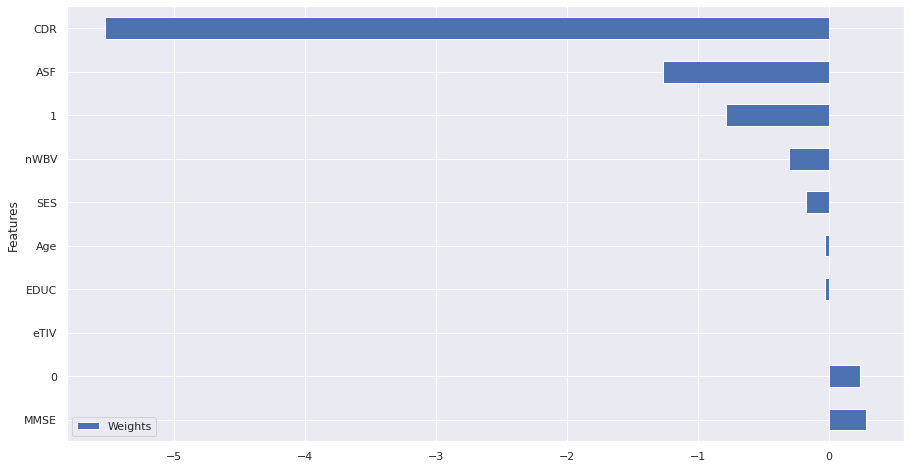

In [85]:
sorted_weights = sorted(zip(clf.coef_.ravel(), x.columns), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
df = pd.DataFrame({'Features': features, 'Weights':weights})
ax = df.plot.barh(x='Features', y='Weights', rot=0, )

(array([25.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 39.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

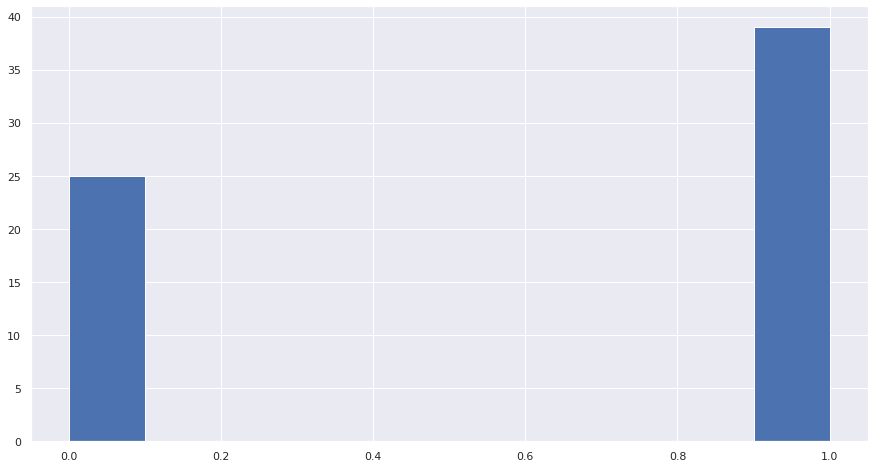

In [86]:
plt.hist(y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


(array([14.,  5.,  4.,  1.,  0.,  1.,  0.,  2.,  8., 29.]),
 array([3.67640381e-06, 9.68077538e-02, 1.93611831e-01, 2.90415909e-01,
        3.87219986e-01, 4.84024063e-01, 5.80828141e-01, 6.77632218e-01,
        7.74436295e-01, 8.71240373e-01, 9.68044450e-01]),
 <a list of 10 Patch objects>)

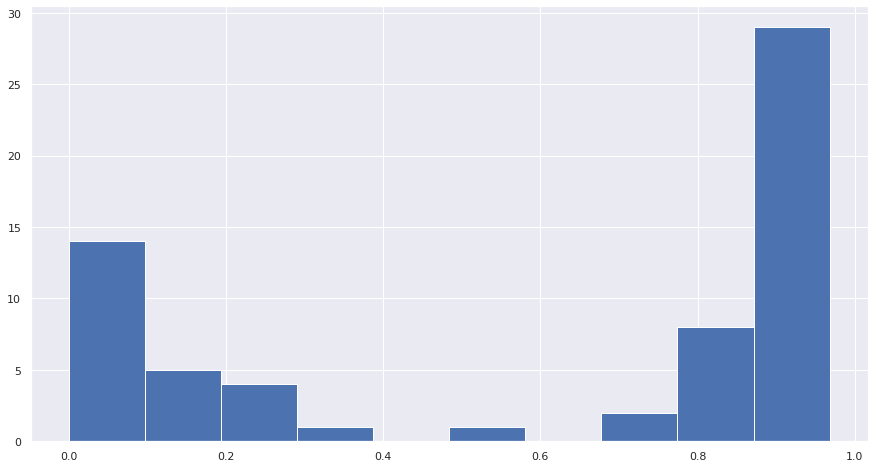

In [87]:
plt.hist(clf.predict_proba(x_test)[:, 1])

## MSE (Mean Squared Error)

In [88]:
mean_squared_error(y_test, logreg_predictions)

0.0

## Accuracy

In [89]:
accuracy = accuracy_score(y_test, logreg_predictions)
accuracy

1.0

## Запись метрик качества 

In [90]:
acc = accuracy_score(y_test, logreg_predictions)
mse = mean_squared_error(y_test, logreg_predictions)
mae = mean_absolute_error(y_test, logreg_predictions)
mape = mean_absolute_percentage_error(y_test, logreg_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Logistic Regression', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Стохастический градиентный спуск || SGD Stochastic Gradient Descent

---



## Выбор оптимальных гиперпараметров и тренировка модели

In [91]:
grid_searcher = GridSearchCV(SGDClassifier(),
                             param_grid={'fit_intercept': [True, False],
                                        # 'max_iter': range(50, 2000, 200),
                                         'alpha': np.linspace(0.00001, 0.1, 10),
                                         'epsilon': np.linspace(0.00001, 0.001, 10)},
                             cv=5)
grid_searcher.fit(x_train.values, y_train.values)


GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': array([1.000e-05, 1.112e-02, 2.223e-02, 3.334e-02, 4.445e-02, 5.556e-02,
       6.667e-02, 7.778e-02, 8.889e-02, 1.000e-01]),
                         'epsilon': array([1.0e-05, 1.2e-04, 2.3e-04, 3.4e-04, 4.5e-04, 5.6e-04, 6.7e-04,
       7.8e-04, 8.9e-04, 1.0e-03]),
                         'fit_intercept': [True, False]})

In [92]:
grid_searcher.best_params_

{'alpha': 0.03334000000000001, 'epsilon': 0.00067, 'fit_intercept': False}

## Создание предсказаний

In [93]:
sgd_predictions = grid_searcher.predict(x_test.values)

## MSE (Mean Squared Error)

In [94]:
mean_squared_error(y_test, sgd_predictions)

0.390625

## Accuracy

In [95]:
accuracy = accuracy_score(y_test, sgd_predictions)
accuracy

0.609375

### Зависимость Accuracy от Alpha

In [96]:
metrics = []
for n in np.linspace(0.00001, 0.1, 100):
  sgd = SGDClassifier(alpha=n)
  scores = cross_val_score(sgd, x_train.values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Alpha')

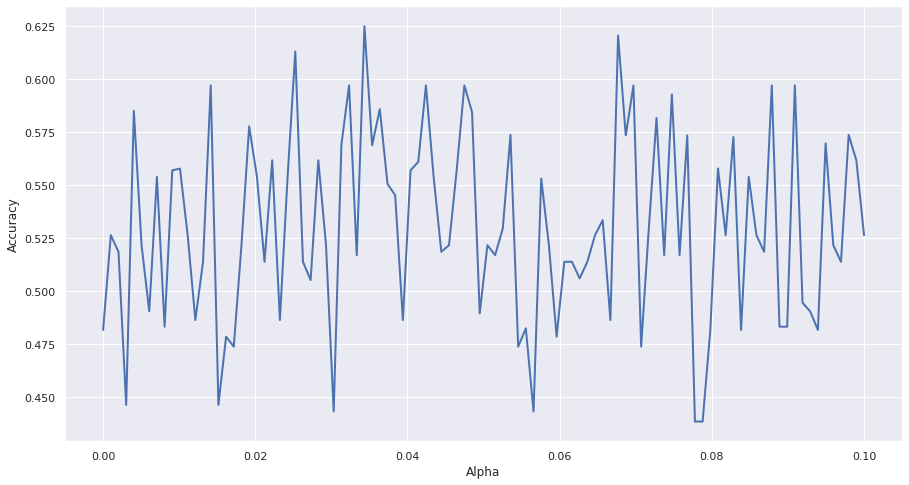

In [97]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(np.linspace(0.00001, 0.1, 100), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('Alpha')

### Зависимость Accuracy от Epsilon

In [98]:
metrics = []
for n in np.linspace(0.00001, 0.001, 100):
  sgd = SGDClassifier(epsilon=n)
  scores = cross_val_score(sgd, x_train.values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Epsilon')

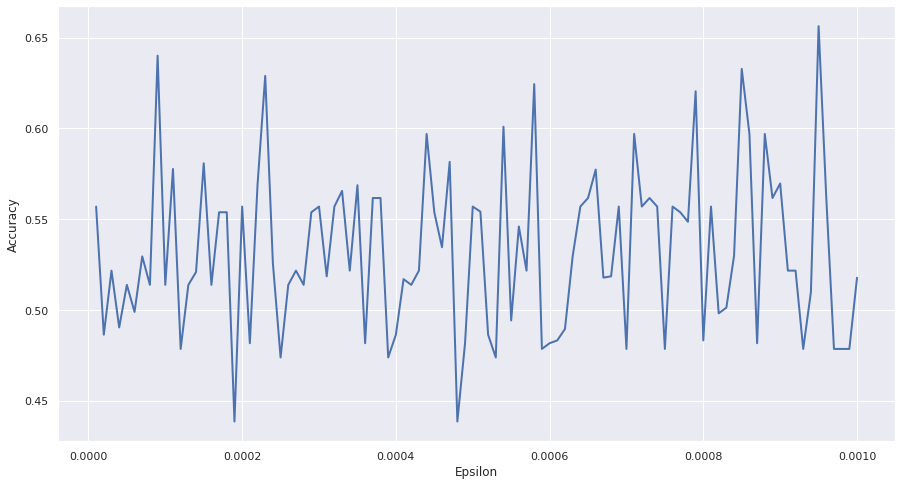

In [99]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(np.linspace(0.00001, 0.001, 100), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')

## Запись метрик качества 

In [100]:
acc = accuracy_score(y_test, sgd_predictions)
mse = mean_squared_error(y_test, sgd_predictions)
mae = mean_absolute_error(y_test, sgd_predictions)
mape = mean_absolute_percentage_error(y_test, sgd_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Stochastic Gradient Descent', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Линейный дискриминантный анализ || LDA Linear Discriminant Analysis

In [101]:
lda = LinearDiscriminantAnalysis(n_components=1)

lda.fit(x_train.values, y_train.values)

LinearDiscriminantAnalysis(n_components=1)

## Создание предсказаний

In [102]:
lda_predictions = lda.predict(x_test.values)

## MSE (Mean Squared Error)

In [103]:
mean_squared_error(y_test, lda_predictions)

0.0

## Accuracy

In [104]:
accuracy = accuracy_score(y_test, lda_predictions)
accuracy

1.0

## Запись метрик качества 

In [105]:
acc = accuracy_score(y_test, lda_predictions)
mse = mean_squared_error(y_test, lda_predictions)
mae = mean_absolute_error(y_test, lda_predictions)
mape = mean_absolute_percentage_error(y_test, lda_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Linear Discriminant Analysis', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Наивный байесовский классификатор || Naive Bayes classifier

---



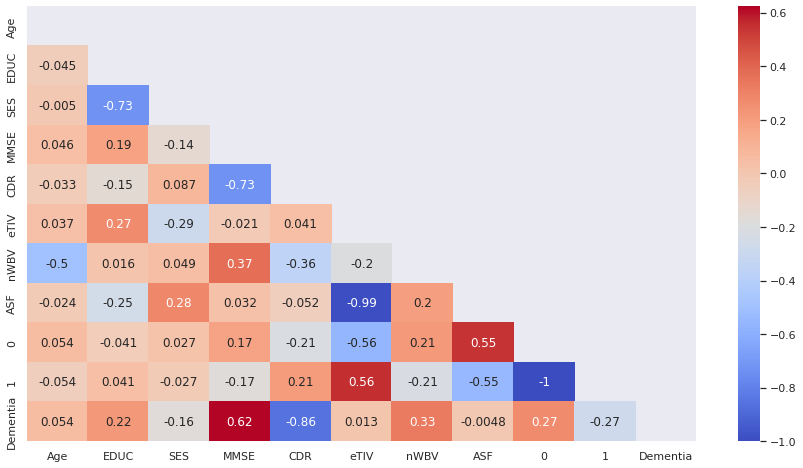

In [106]:
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True, mask=matrix, cmap='coolwarm')

## Коррелирующие пары



ASF - ***eTIV*** 99% (-0.4% // 1.3%)

***CDR*** - MMSE 73% (-86% // 62%)

SES - ***EDUC*** 73% (-16% // 22%)

AGE - nWBV 50% (5.4% // 33%)

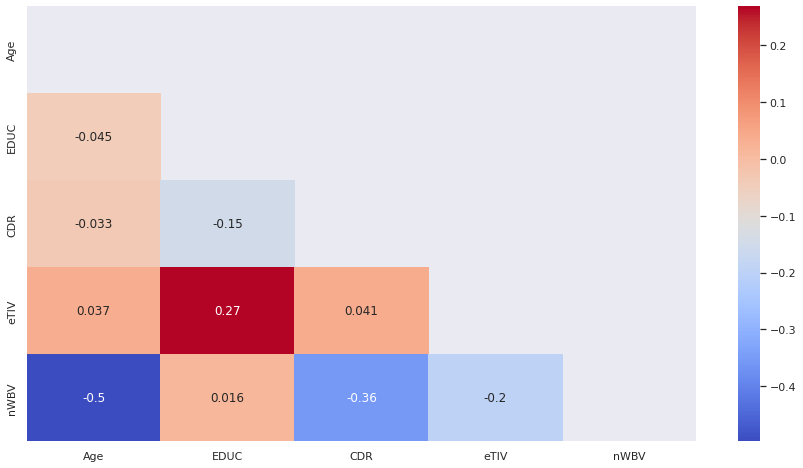

In [107]:
# 'Age','EDUC', 'SES', 'MMSE', 'CDR', 'eTIV','nWBV', 'ASF', 'Dementia'
wo_corr = data[['Age','EDUC', 'CDR', 'eTIV','nWBV']]

matrix = np.triu(wo_corr.corr())
sns.heatmap(wo_corr.corr(), annot=True, mask=matrix, cmap='coolwarm')

## Тренировка моделей

In [108]:
gaus_nb = GaussianNB()
compl_nb = ComplementNB()
multinom_nb = MultinomialNB()

gaus_nb.fit(x_train[['Age','EDUC', 'CDR', 'eTIV','nWBV']].values, y_train.values)
compl_nb.fit(x_train[['Age','EDUC', 'CDR', 'eTIV','nWBV']].values, y_train.values)
multinom_nb.fit(x_train[['Age','EDUC', 'CDR', 'eTIV','nWBV']].values, y_train.values)

MultinomialNB()

In [109]:
gnb_predictions = gaus_nb.predict(x_test[['Age','EDUC', 'CDR', 'eTIV','nWBV']].values)
cnb_predictions = compl_nb.predict(x_test[['Age','EDUC', 'CDR', 'eTIV','nWBV']].values)
mnb_predictions = multinom_nb.predict(x_test[['Age','EDUC', 'CDR', 'eTIV','nWBV']].values)

## MSE (Mean Squared Error)

### Gaussin

In [110]:
mean_squared_error(y_test, gnb_predictions)

0.0

In [111]:
gaus_nb.fit(x_train.values, y_train.values)
mean_squared_error(y_test, gaus_nb.predict(x_test.values))

0.0

### Complement

In [112]:
mean_squared_error(y_test, cnb_predictions)

0.0

In [113]:
compl_nb.fit(x_train.values, y_train.values)
mean_squared_error(y_test, compl_nb.predict(x_test.values))

0.0625

### Multinomial

In [114]:
mean_squared_error(y_test, mnb_predictions)

0.0

In [115]:
multinom_nb.fit(x_train.values, y_train.values)
mean_squared_error(y_test, multinom_nb.predict(x_test.values))

0.046875

## Accuracy

In [116]:
accuracy = accuracy_score(y_test, cnb_predictions)
accuracy

1.0

### Зависимость Accuracy от Alpha в Complement Naive Bayes

In [117]:
metrics = []
for n in np.linspace(0, 300, 100):
  cnb = ComplementNB(alpha=n)
  scores = cross_val_score(cnb, x_train[['Age','EDUC', 'CDR', 'eTIV','nWBV']].values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Alpha')

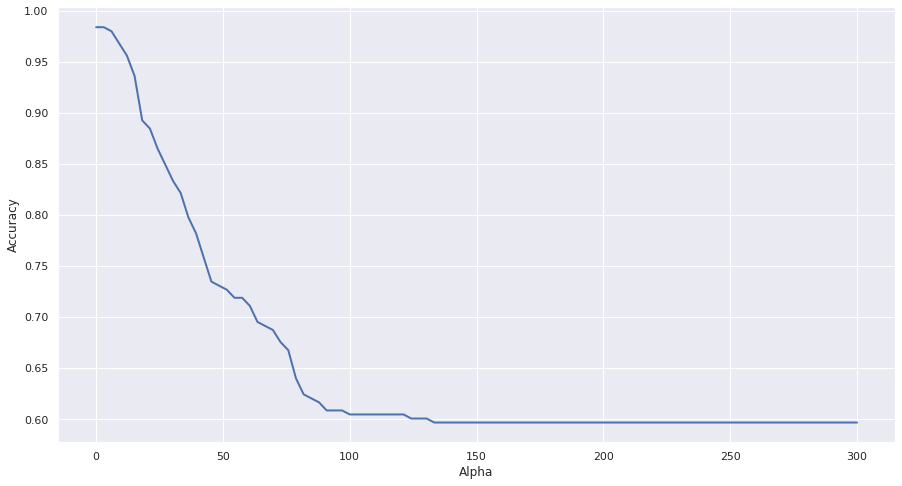

In [118]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(np.linspace(0, 300, 100), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('Alpha')

## Запись метрик качества 

In [119]:
acc = accuracy_score(y_test, gnb_predictions)
mse = mean_squared_error(y_test, gnb_predictions)
mae = mean_absolute_error(y_test, gnb_predictions)
mape = mean_absolute_percentage_error(y_test, gnb_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Gaussin Naive Bayes', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

In [120]:
acc = accuracy_score(y_test, cnb_predictions)
mse = mean_squared_error(y_test, cnb_predictions)
mae = mean_absolute_error(y_test, cnb_predictions)
mape = mean_absolute_percentage_error(y_test, cnb_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Complement Naive Bayes', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

In [121]:
acc = accuracy_score(y_test, mnb_predictions)
mse = mean_squared_error(y_test, mnb_predictions)
mae = mean_absolute_error(y_test, mnb_predictions)
mape = mean_absolute_percentage_error(y_test, mnb_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Multinomial Naive Bayes', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Метод опорных векторов || SVM Support Vector Machine (~SVC)

---



## Выбор оптимальных гиперпараметров

In [122]:
grid_searcher = GridSearchCV(SVC(),
                             param_grid = {'C': np.linspace(0.00001, 1, 100),
                                           'class_weight': ['balanced', None]},
                             cv = 5)

In [123]:
'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

('linear', 'poly', 'rbf', 'sigmoid', 'precomputed')

## Тренировка модели и создание предсканий

In [124]:
grid_searcher.fit(x_train.values, y_train.values)
svc_predictions = grid_searcher.predict(x_test.values)

In [125]:
grid_searcher.best_params_

{'C': 1e-05, 'class_weight': None}

## MSE (Mean Squared Error)

In [126]:
mean_squared_error(y_test, svc_predictions)

0.390625

### Зависимость MSE от C

In [127]:
metrics = []
for n in np.linspace(0.00001, 1, 10):
  svc = SVC(C=n, class_weight=None, kernel='linear')
  scores = cross_val_score(svc, x_train.values, y_train.values, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

In [128]:
'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

('linear', 'poly', 'rbf', 'sigmoid', 'precomputed')

In [129]:
metrics = []
for n in np.linspace(0.00001, 1, 10):
  svc = SVC(C=n, class_weight=None, kernel='poly')
  scores = cross_val_score(svc, x_train.values, y_train.values, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'C')

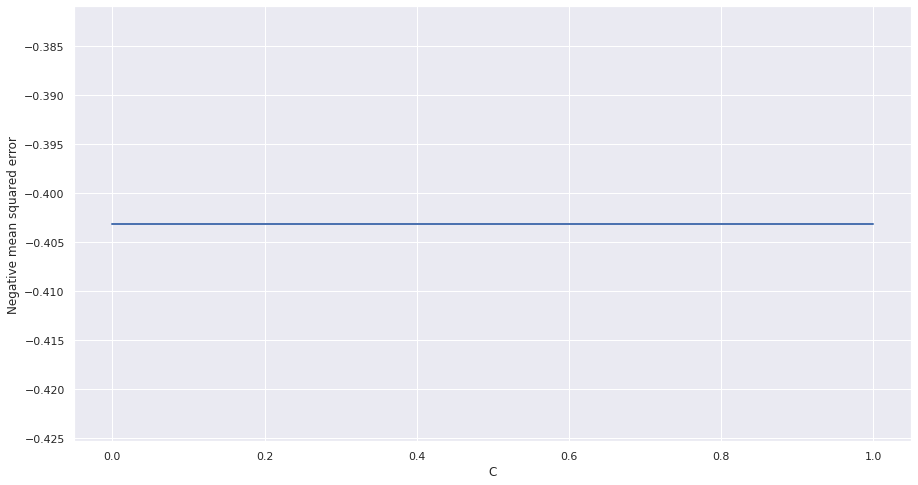

In [130]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(np.linspace(0.00001, 1, 10), metrics, linewidth=2)
plt.ylabel('Negative mean squared error')
plt.xlabel('C')

## Accuracy

In [131]:
accuracy = accuracy_score(y_test, svc_predictions)
accuracy

0.609375

### Зависимость Accuracy от C

In [132]:
metrics = []
for n in np.linspace(0.00001, 1, 1000):
  svc = SVC(C=n)
  scores = cross_val_score(svc, x_train.values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'C')

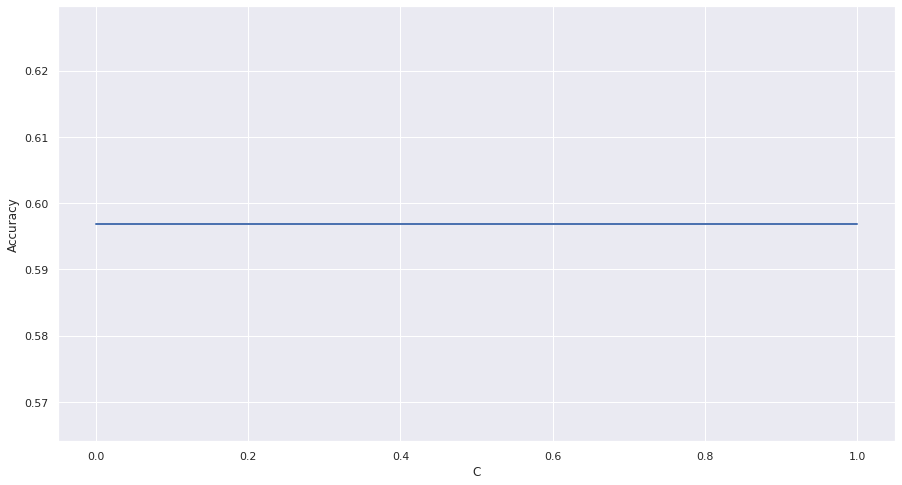

In [133]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(np.linspace(0.00001, 1, 1000), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('C')

## Интерпретация

In [134]:
s = SVC()
s.fit(x_train.values, y_train.values)
s.support_vectors_.shape

(210, 10)

## Запись метрик качества 

In [135]:
acc = accuracy_score(y_test, svc_predictions)
mse = mean_squared_error(y_test, svc_predictions)
mae = mean_absolute_error(y_test, svc_predictions)
mape = mean_absolute_percentage_error(y_test, svc_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Support Vector Machine', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Решающие деревья
---



## Выбор оптимальных гиперпараметров

In [136]:
grid_searcher = GridSearchCV(DecisionTreeClassifier(),
                             param_grid = {'splitter': ['best', 'random'],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': range(1, 20, 5),
                                           "min_samples_split" : range(2, 22, 5), 
                                           },
                             cv = 5)

## Тренировка модели и создание предсканий

In [137]:
grid_searcher.fit(x_train.values, y_train.values)
tree_predictions = grid_searcher.predict(x_test.values)

In [138]:
grid_searcher.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [139]:
x.columns

Index(['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 0, 1], dtype='object')

In [140]:
tree1 = DecisionTreeClassifier()
tree1.fit(x_train.values, y_train.values)

print(export_text(tree1, feature_names=['Age','EDUC', 'SES', 'MMSE', 'CDR', 'eTIV','nWBV', 'ASF', 0, 1], ))

accuracy_score(y_test.values, tree1.predict(x_test.values))

|--- CDR <= 0.25
|   |--- class: 1
|--- CDR >  0.25
|   |--- ASF <= 1.03
|   |   |--- EDUC <= 13.50
|   |   |   |--- nWBV <= 0.70
|   |   |   |   |--- class: 0
|   |   |   |--- nWBV >  0.70
|   |   |   |   |--- class: 1
|   |   |--- EDUC >  13.50
|   |   |   |--- class: 0
|   |--- ASF >  1.03
|   |   |--- class: 0



1.0

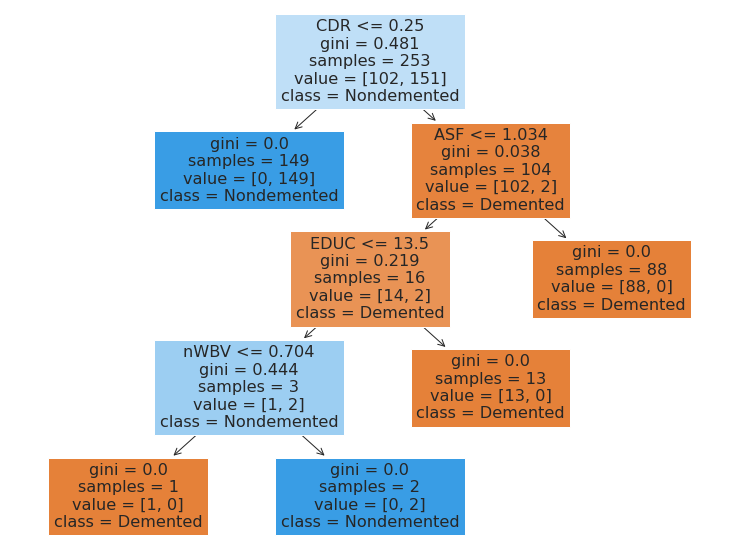

In [192]:
# from IPython.core.pylabtools import figsize

fig = plt.figure(figsize=(13,10))
_ = plot_tree(tree1, 
              feature_names=['Age','EDUC', 'SES', 'MMSE', 'CDR', 'eTIV','nWBV', 'ASF', 0, 1],  
              class_names=['Demented', 'Nondemented'],
              filled=True)

## MSE (Mean Squared Error)

In [142]:
mean_squared_error(y_test, tree_predictions)

0.0

### Зависимость MSE от max_depth

In [143]:
metrics = []
for n in range(1, 100):
  tree = DecisionTreeClassifier(max_depth=n)
  scores = cross_val_score(tree, x_train.values, y_train.values, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'max_depth')

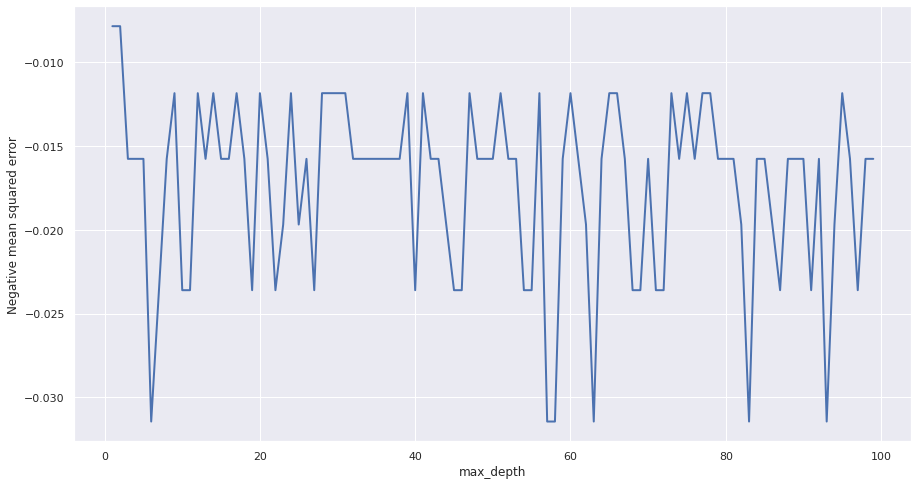

In [144]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(1,100), metrics, linewidth=2)
plt.ylabel('Negative mean squared error')
plt.xlabel('max_depth')

### Зависимость MSE от min_samples_split

In [145]:
metrics = []
for n in range(2, 100):
  tree = DecisionTreeClassifier(min_samples_split=n)
  scores = cross_val_score(tree, x_train.values, y_train.values, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'min_samples_split')

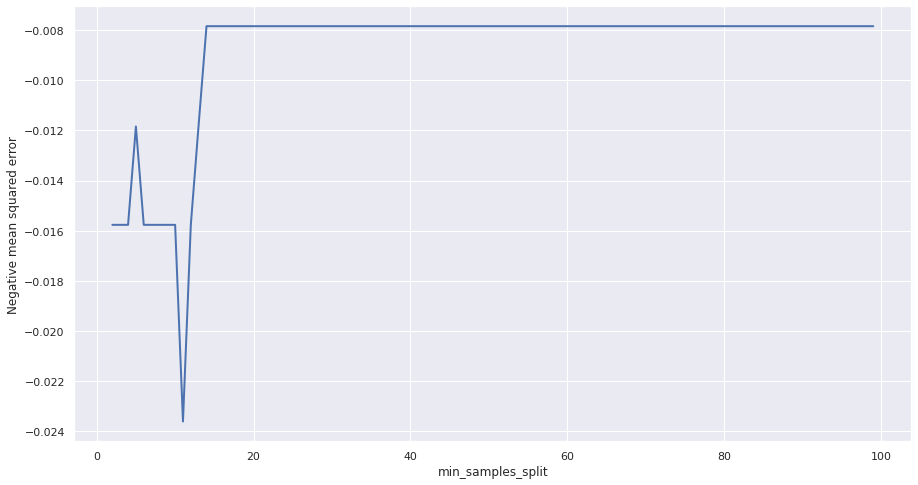

In [146]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(2,100), metrics, linewidth=2)
plt.ylabel('Negative mean squared error')
plt.xlabel('min_samples_split')

## Accuracy

In [147]:
accuracy = accuracy_score(y_test, tree_predictions)
accuracy

1.0

### Зависимость Accuracy от max_depth

In [148]:
metrics = []
for n in range(1, 100):
  tree = DecisionTreeClassifier(max_depth=n)
  scores = cross_val_score(tree, x_train.values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'max_depth')

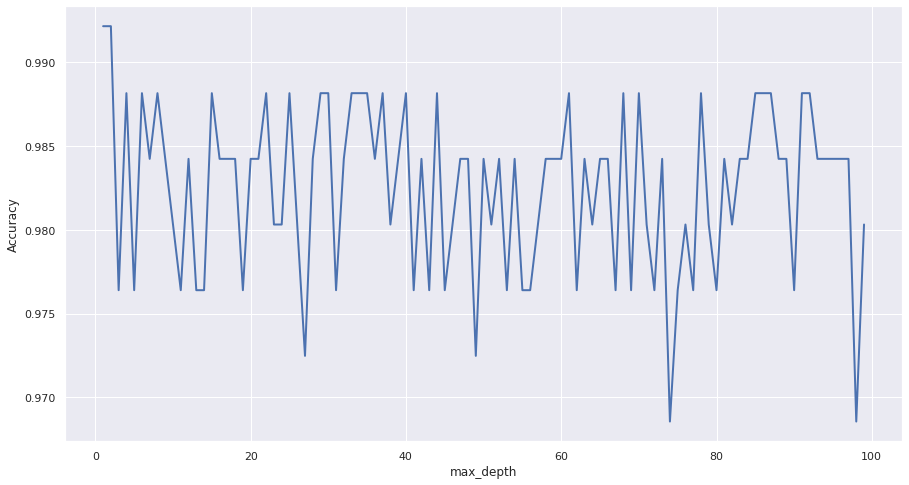

In [149]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(1,100), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('max_depth')

### Зависимость Accuracy от min_samples_split

In [150]:
metrics = []
for n in range(2, 100):
  tree = DecisionTreeClassifier(min_samples_split=n)
  scores = cross_val_score(tree, x_train.values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'min_samples_split')

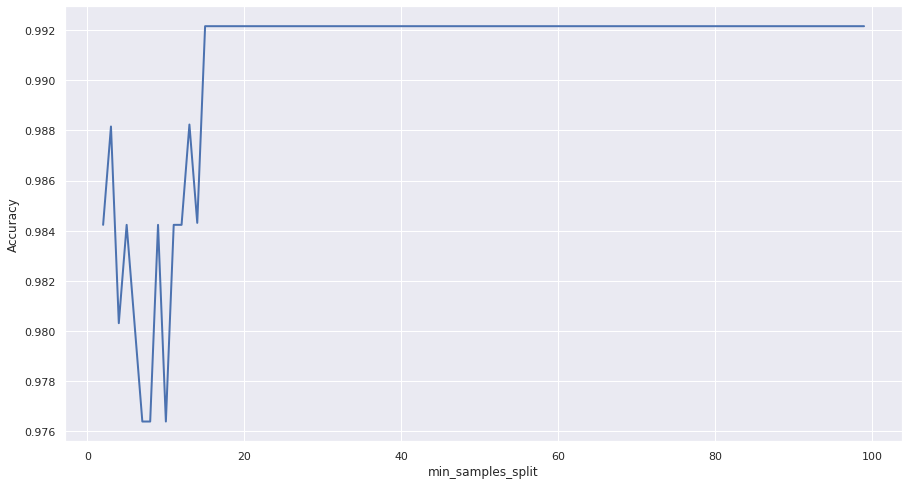

In [151]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(2,100), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('min_samples_split')

## Запись метрик качества 

In [152]:
acc = accuracy_score(y_test, tree_predictions)
mse = mean_squared_error(y_test, tree_predictions)
mae = mean_absolute_error(y_test, tree_predictions)
mape = mean_absolute_percentage_error(y_test, tree_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Decision Trees', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Градиентный бустинг || Gradient Boosting

---



## Catboost

In [153]:
clf = CatBoostClassifier(iterations=300, logging_level='Silent')

clf.fit(x_train, y_train)

print(accuracy_score(y_test, clf.predict(x_test)))

1.0


## XGBoost

In [154]:
xgb = XGBClassifier()

xgb.fit(x_train, y_train)

print(accuracy_score(y_test, xgb.predict(x_test)))

1.0


## scikit-learn

In [155]:
gbc = XGBClassifier()

gbc.fit(x_train, y_train)

print(accuracy_score(y_test, gbc.predict(x_test)))

1.0


# Случайный лес || Random Forest

---




## Выбор оптимальных гиперпараметров

59 раз - изменение диапазона параметров при запуске гридсерча

In [156]:
grid_searcher = GridSearchCV(RandomForestClassifier(),
                             param_grid = {'n_estimators': range(1, 50, 10),
                                           'max_features': [0.00001, 0.0001, 0.01],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': range(1, 20, 5),
                                           "min_samples_split" : range(2, 22, 5), 
                                           'bootstrap': [True, False]
                                           },
                             cv = 5)

## Тренировка модели и создание предсканий

In [157]:
grid_searcher.fit(x_train.values, y_train.values)
randfor_predictions = grid_searcher.predict(x_test.values)

In [158]:
grid_searcher.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 0.01,
 'min_samples_split': 7,
 'n_estimators': 31}

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 1e-05,
 'min_samples_split': 11,
 'n_estimators': 31}
 MSE = 0, Accuracy = 1.0

***Та же MSE=0.015625 и при таких параметрах***

'bootstrap': True,

 'criterion': 'gini',

 'max_depth': 6,

 'max_features': 7e-05,

 'min_samples_split': 4,

 'n_estimators': 45}

## MSE (Mean Squared Error)

In [159]:
mean_squared_error(y_test, randfor_predictions)

0.0

### Зависимость MSE от max_depth

In [160]:
metrics = []
for n in range(1, 10):
  forest = RandomForestClassifier(max_depth=n)
  scores = cross_val_score(forest, x_train.values, y_train.values, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'max_depth')

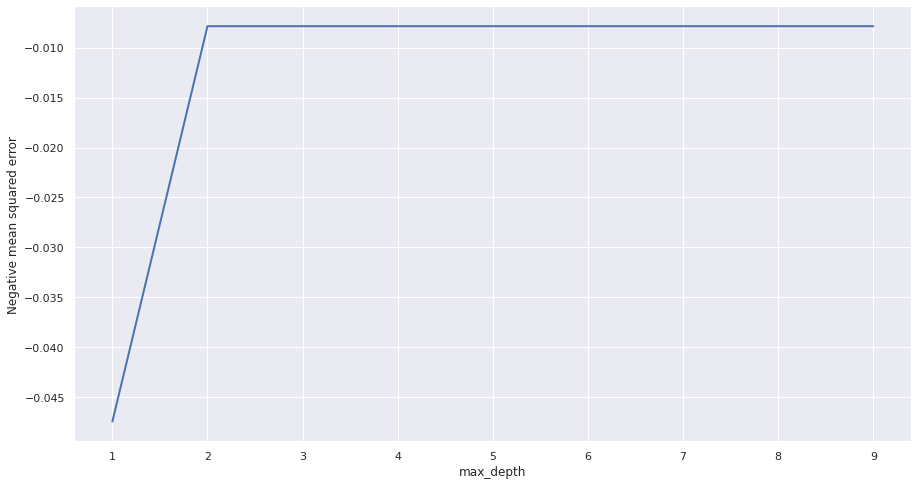

In [161]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(1, 10), metrics, linewidth=2)
plt.ylabel('Negative mean squared error')
plt.xlabel('max_depth')

### Зависимость MSE от n_estimators

In [162]:
metrics = []
for n in range(1, 70):
  forest = RandomForestClassifier(n_estimators=n)
  scores = cross_val_score(forest, x_train.values, y_train.values, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'n_estimators')

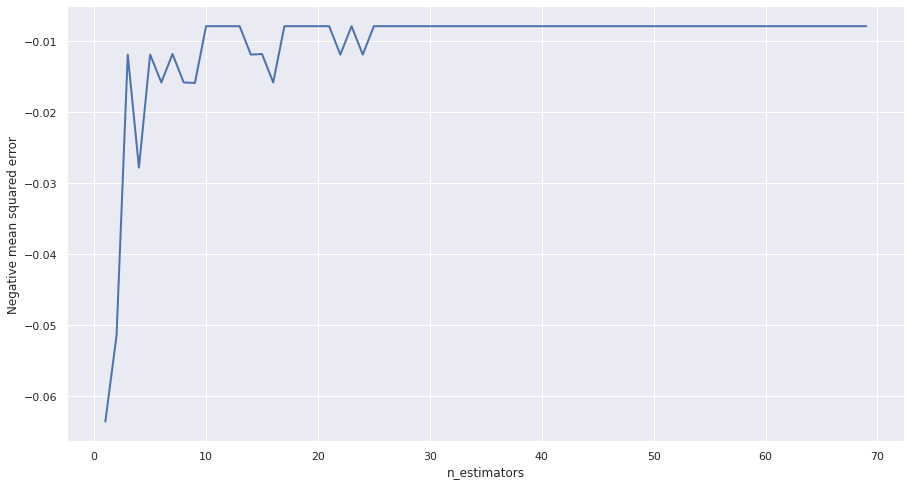

In [163]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(1, 70), metrics, linewidth=2)
plt.ylabel('Negative mean squared error')
plt.xlabel('n_estimators')

### Зависимость MSE от min_samples_plit

In [164]:
metrics = []
for n in range(50, 150):
  forest = RandomForestClassifier(min_samples_split=n)
  scores = cross_val_score(forest, x_train.values, y_train.values, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'min_samples_split')

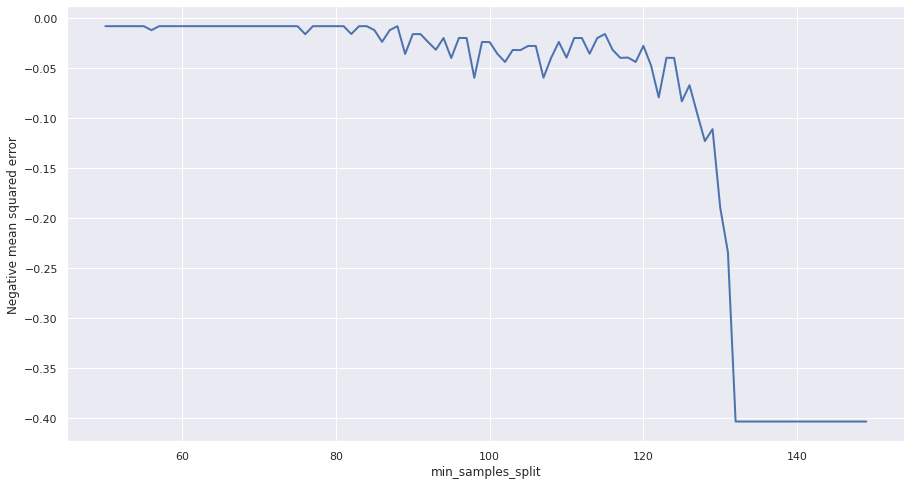

In [165]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(50, 150), metrics, linewidth=2)
plt.ylabel('Negative mean squared error')
plt.xlabel('min_samples_split')

### Зависимость MSE от max_features

In [166]:
metrics = []
for n in np.linspace(0.0001, 1, 100):
  forest = RandomForestClassifier(max_features=n)
  scores = cross_val_score(forest, x_train.values, y_train.values, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'max_features')

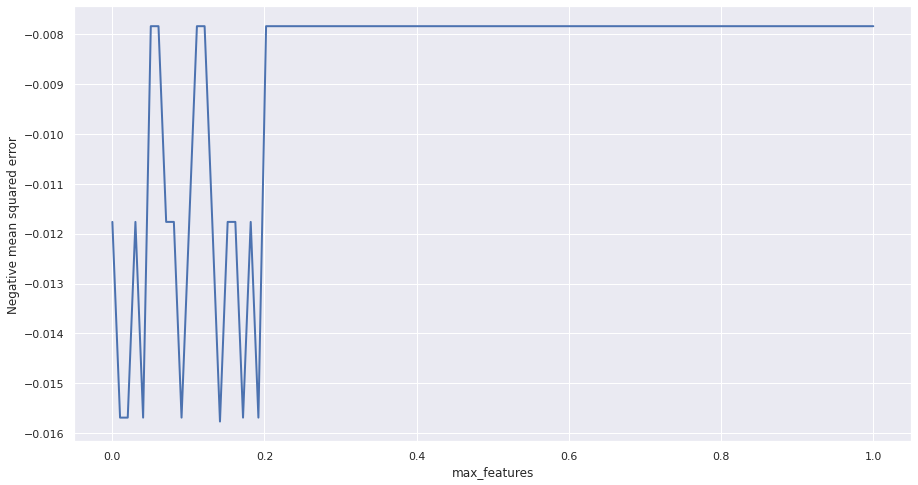

In [167]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(np.linspace(0.0001, 1, 100), metrics, linewidth=2)
plt.ylabel('Negative mean squared error')
plt.xlabel('max_features')

## Accuracy

In [168]:
accuracy = accuracy_score(y_test, randfor_predictions)
accuracy

1.0

### Зависимость Accuracy от max_depth

In [169]:
metrics = []
for n in range(1, 10):
  forest = RandomForestClassifier(max_depth=n)
  scores = cross_val_score(forest, x_train.values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'max_depth')

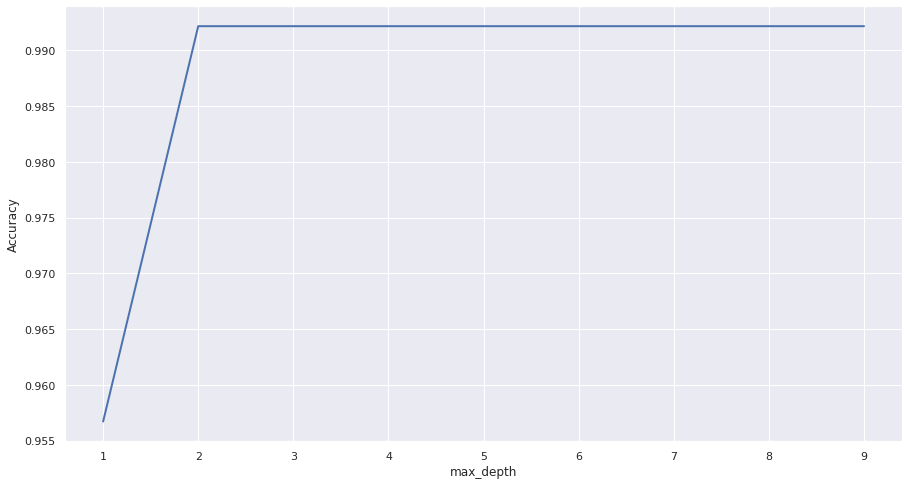

In [170]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(1, 10), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('max_depth')

### Зависимость Accuracy от n_estimators

In [171]:
metrics = []
for n in range(1, 70):
  forest = RandomForestClassifier(n_estimators=n)
  scores = cross_val_score(forest, x_train.values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'n_estimators')

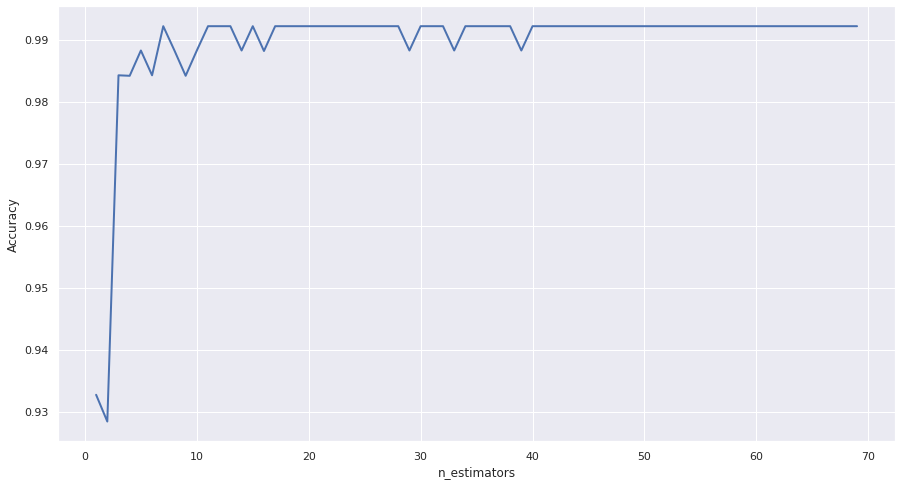

In [172]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(1, 70), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')

### Зависимость Accuracy от min_samples_plit

In [173]:
metrics = []
for n in range(50, 150):
  forest = RandomForestClassifier(min_samples_split=n)
  scores = cross_val_score(forest, x_train.values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'min_samples_split')

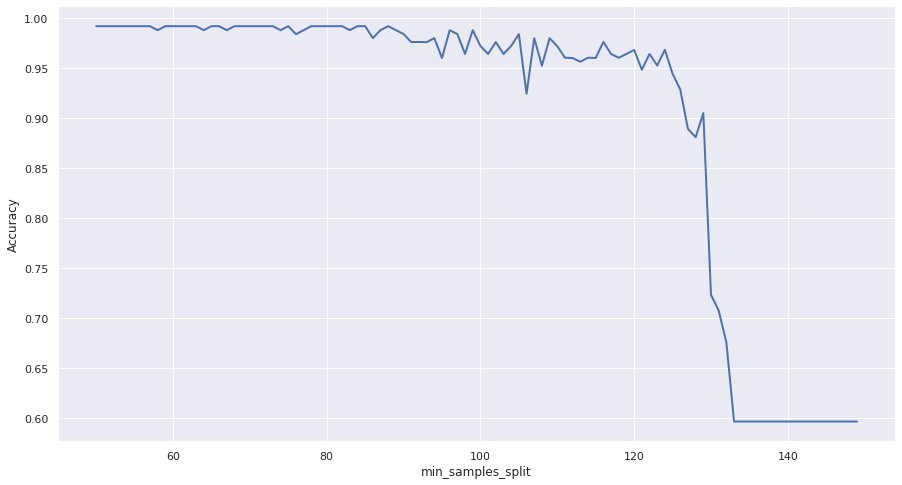

In [174]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(range(50, 150), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('min_samples_split')

### Зависимость Accuracy от max_features

In [175]:
metrics = []
for n in np.linspace(0.0001, 1, 100):
  forest = RandomForestClassifier(max_features=n)
  scores = cross_val_score(forest, x_train.values, y_train.values, cv=5, scoring='accuracy')
  metrics.append(np.mean(scores))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'max_features')

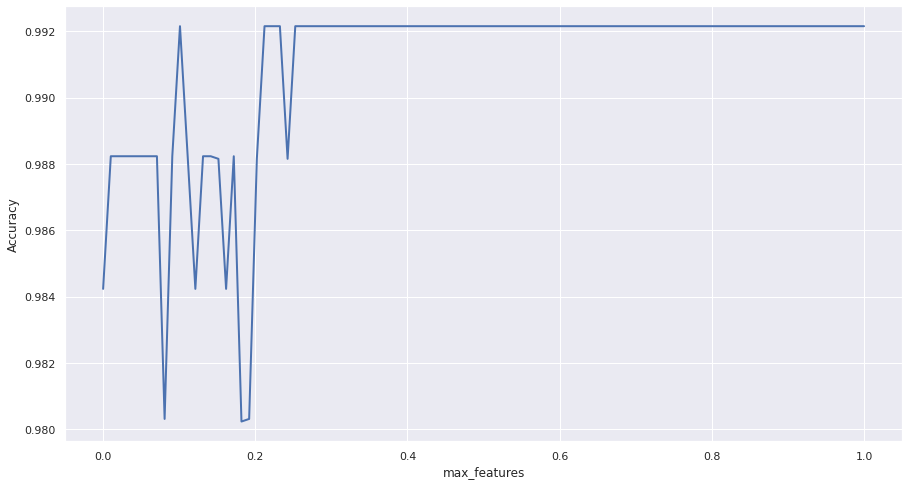

In [176]:
sns.set_style(style='whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(np.linspace(0.0001, 1, 100), metrics, linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('max_features')

## Запись метрик качества 

In [177]:
acc = accuracy_score(y_test, randfor_predictions)
mse = mean_squared_error(y_test, randfor_predictions)
mae = mean_absolute_error(y_test, randfor_predictions)
mape = mean_absolute_percentage_error(y_test, randfor_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Random Forest', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Bagging Classifier

---



## SVC

In [178]:
bag = BaggingClassifier(base_estimator=SVC(C= 1e-05, class_weight='balanced'))

bag.fit(x_train.values, y_train.values)

bag_predictions = bag.predict(x_test.values)

In [179]:
print('SVC bagging accuracy', accuracy_score(y_test, bag_predictions))
print('SVC accuracy        ', accuracy_score(y_test, svc_predictions))

SVC bagging accuracy 0.609375
SVC accuracy         0.609375


In [180]:
acc = accuracy_score(y_test, bag_predictions)
mse = mean_squared_error(y_test, bag_predictions)
mae = mean_absolute_error(y_test, bag_predictions)
mape = mean_absolute_percentage_error(y_test, bag_predictions)

model_comparison = model_comparison.append({'Algorithm': 'SVC Bagging', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

## Logistic Regression

In [ ]:
bag = BaggingClassifier(base_estimator=LogisticRegression(C= 334.0, fit_intercept = False, max_iter = 91))

bag.fit(x_train.values, y_train.values)

bag_predictions = bag.predict(x_test.values)

In [182]:
print('SVC bagging accuracy', accuracy_score(y_test, bag_predictions))
print('SVC accuracy        ', accuracy_score(y_test, logreg_predictions))

SVC bagging accuracy 1.0
SVC accuracy         1.0


In [183]:
acc = accuracy_score(y_test, bag_predictions)
mse = mean_squared_error(y_test, bag_predictions)
mae = mean_absolute_error(y_test, bag_predictions)
mape = mean_absolute_percentage_error(y_test, bag_predictions)

model_comparison = model_comparison.append({'Algorithm': 'Logistic Regression Bagging', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Stacking Classifier

---



In [184]:
def get_models():
    models = dict()
    models['LogReg'] = LogisticRegression(max_iter=10000)
    models['kNN'] = KNeighborsClassifier()
    models['Tree'] = DecisionTreeClassifier()
    models['SVC'] = SVC(max_iter=1000)
    models['Bayes'] = GaussianNB()
    models['Stacking'] = get_stacking()
    return models

def get_stacking():
	# base models
	level0 = list()
	level0.append(('lr', LogisticRegression(max_iter=10000)))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC(max_iter=1000)))
	level0.append(('bayes', GaussianNB()))
	# meta model
	level1 = LogisticRegression(max_iter=10000)
	# stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

models = get_models()

results, names = list(), list()

for name, model in models.items():
    scores = cross_val_score(model, x_train.values, y_train.values, scoring='accuracy', cv=5)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>LogReg 0.956 (0.041)
>kNN 0.672 (0.046)
>Tree 0.976 (0.015)
>SVC 0.597 (0.008)
>Bayes 0.988 (0.010)
>Stacking 0.992 (0.010)


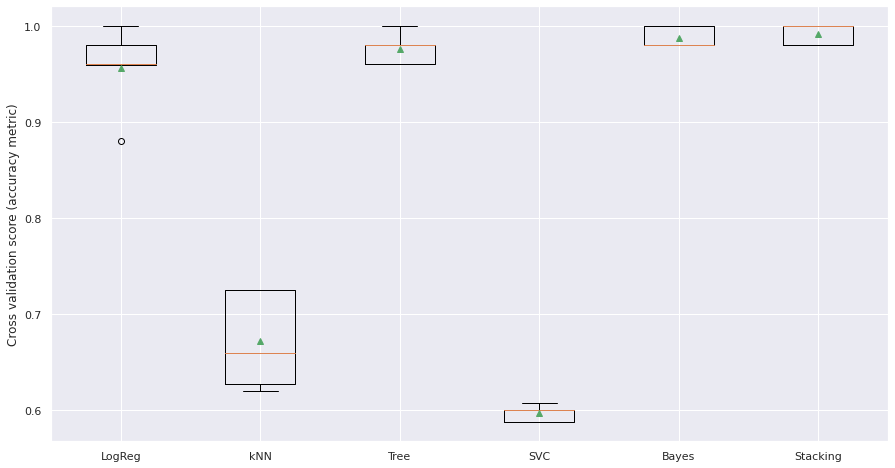

In [185]:
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc = {'figure.figsize':(15,8)})

plt.boxplot(results, labels=names, showmeans=True)

plt.ylabel('Cross validation score (accuracy metric)')
plt.show()

Text(0.5, 0, 'LogReg                                kNN                                  Tree                                 SVC                                    Bayes                              Stacking')

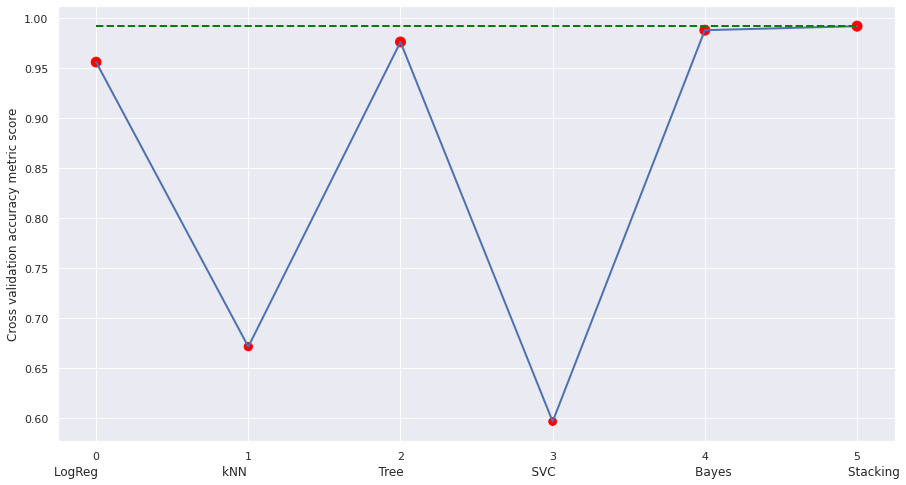

In [186]:
a=list()
[a.append(mean(results[i])) for i in range(6)]

plt.scatter(range(6), a, color='red', s = np.multiply(a, 100))
plt.plot(range(6), a, linewidth=2)
plt.plot(range(6), [max(a)]*6, linestyle='dashed', linewidth=2, color='green')

plt.ylabel('Cross validation accuracy metric score')
plt.xlabel('LogReg                                kNN                                  Tree                                 SVC                                    Bayes                              Stacking')

## Запись метрик качества 

In [187]:
# acc = accuracy_score(y_test, knn_predictions)
# mse = mean_squared_error(y_test, knn_predictions)
# mae = mean_absolute_error(y_test, knn_predictions)
# mape = mean_absolute_percentage_error(y_test, knn_predictions)

# model_comparison.append({'Algorithm': 'Stacking', 'Accuracy': acc, 'MSE': mse, 'MAE': mae, 'MAPE': mape}, ignore_index=True)

# Сравнение эффективности моделей на основе метрик 

In [188]:
model_comparison

,Accuracy,MSE,MAE,MAPE,Algorithm
0,0.781250,0.218750,0.218750,7.036874e+14,K Nearest Neighbors
1,0.781250,0.063759,0.177490,5.500057e+14,Linear Regression
2,0.984375,0.015625,0.015625,7.036874e+13,Rounded Linear Regression
3,0.984375,0.063645,0.177255,5.493562e+14,Ridge Regression
4,0.984375,0.015625,0.015625,7.036874e+13,Round Ridge Regression
5,0.781250,0.218750,0.218750,7.036874e+14,Ridge Regression Classifier
6,1.000000,0.000000,0.000000,0.000000e+00,Logistic Regression
7,0.609375,0.390625,0.390625,1.759219e+15,Stochastic Gradient Descent
8,1.000000,0.000000,0.000000,0.000000e+00,Linear Discriminant Analysis
9,1.000000,0.000000,0.000000,0.000000e+00,Gaussin Naive Bayes


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec0c5debd0>,
      dtype=object)

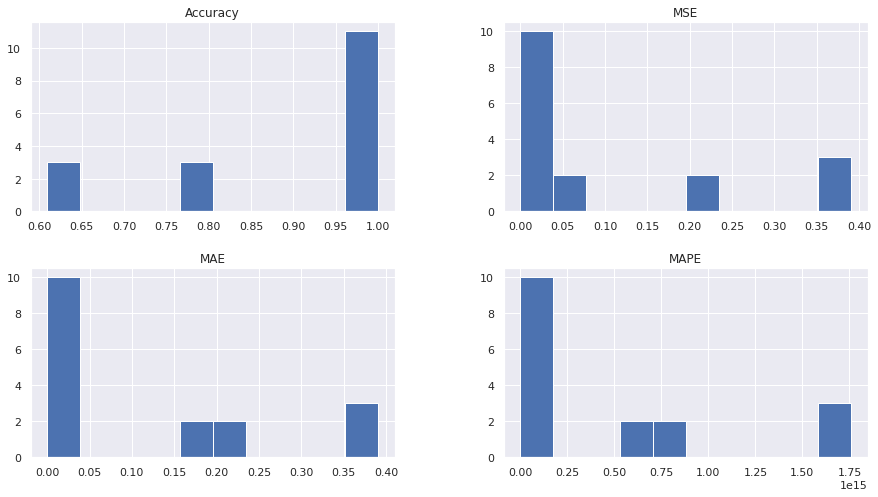

In [189]:
model_comparison.hist()

In [190]:
model_comparison['Algorithm']

0              K Nearest Neighbors
1                Linear Regression
2        Rounded Linear Regression
3                 Ridge Regression
4           Round Ridge Regression
5      Ridge Regression Classifier
6              Logistic Regression
7      Stochastic Gradient Descent
8     Linear Discriminant Analysis
9              Gaussin Naive Bayes
10          Complement Naive Bayes
11         Multinomial Naive Bayes
12          Support Vector Machine
13                  Decision Trees
14                   Random Forest
15                     SVC Bagging
16     Logistic Regression Bagging
Name: Algorithm, dtype: object

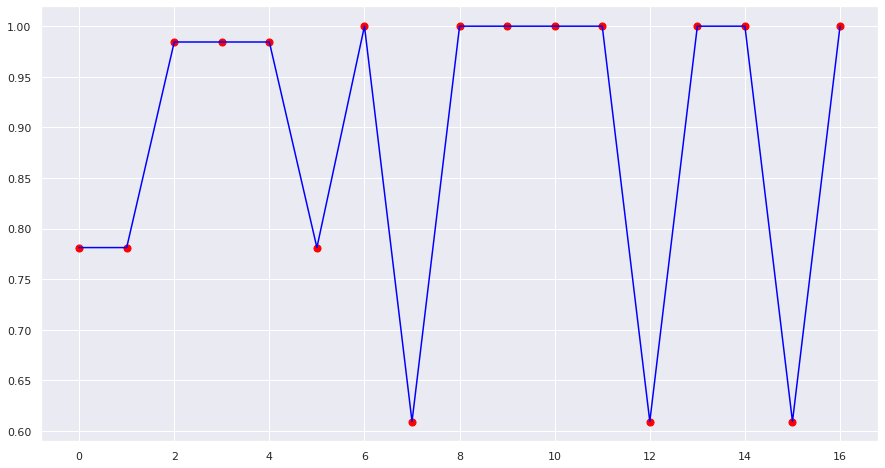

In [191]:
plt.scatter(range(17), model_comparison['Accuracy'], color='red', s=50)
plt.plot(range(17), model_comparison['Accuracy'], color='blue')